## Analysis und Clustering

### Inhaltsverzeichnis
* [Libraries Import](#chapter1)
* [Datensatz Analyse](#chapter2)
    * [Verteilung der Berufsklassen](#section_2_1)
    * [Übersetzen der Daten](#section_2_2)
* [Natural Language Processing](#chapter3)
    * [Stopwörter entfernen](#section_3_1)
    * [Tokenizer und Lemmatizer](#section_3_2)
    * [Themen Übersicht](#section_3_3)
    * [Neue Anforderungen kreieren](#section_3_4)    
* [Clusteanalyse](#chapter4) 
    * [Unbalancierte Daten](#section_4_1)
    * [KMean Clustering](#section_4_2)
    * [Agglomerative Clustering](#section_4_3)
* [Analysis der Anforderungen](#chapter5) 
    * [Data Science](#section_5_1)
    * [Data Analyst](#section_5_2)
    * [Data Engineer](#section_5_3)
    * [AI Engineer](#section_5_4)
    * [ML Engineer](#section_5_5)
    * [Berufe im Vergleich](#section_5_6)

### Import Liberaries  <a class="anchor" id="chapter1"></a>

In [1]:
#!pip install nltk
#!pip install libretranslatepy
#!pip install langdetect 
#!pip install wordcloud
import re
import collections
import itertools
import string

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [2]:
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package omw-1.4 to /home/b1fc/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Dataframe Analysis <a class="anchor" id="chapter2"></a>

In [2]:
df = pd.read_csv("./df_for_topics.csv")
df = df.drop('Unnamed: 0', axis=1)
#df = df[~df['job_data'].str.contains('other')]
df.head(5)

link_text  ai  ai engineer  \
0  Über uns  Unsere über 30 jährige  Erfolgsgesch...   0            0   
1   Unsere über 30 jährige  Erfolgsgeschichte im ...   0            0   
2   Die intelligente  Nutzung von  Daten erlaubt ...   0            0   
3     Vollzeit, ab sofort in  Coburg, unbefristet...   0            0   
4   Die  Pro Sieben Sat.1  Group ist eines der gr...   0            0   

   computer vision  data analyst  data engineer  data scientist  \
0                0             0              0               1   
1                0             0              0               1   
2                0             0              0               0   
3                0             0              0               0   
4                0             0              0               1   

   deep learning  ml  ml engineer  other  
0              0   0            1      0  
1              0   0            0      0  
2              0   0            1      0  
3              0   0            1      0  
4              0   0            0      0

#### Verteilung der Berufsklassen  <a class="anchor" id="chapter2_1"></a>

In [3]:
def countJobs(df):
    '''
    Zählt die Berufe im Datensatz
    :param df: Datensatz, der die Berufe beinhaltet 
    :return: ein Dictionary mit de Berufen und deren Häufigkeit im Datensatz
    '''
    joblist = list(df.columns.values)
    #link_text wird aus der Liste entfernt, da es keine Relevanz hat
    joblist.pop(0)
    counter_list = {job: 0 for job in joblist}
    for job in counter_list:
        counter_list[job] = collections.Counter(df[job])[1]
    return dict(sorted(counter_list.items(), key=lambda item: item[1]))

In [7]:
def plotBar(x, y, title, barh=False):
    '''
    Zeichne entweder einen horizontalen oder vertikalen Balkendiagramm basierend auf dem barh-Parameter
    '''
    if not barh:
        plt.bar(x, y, zorder=2)
    else:
        plt.barh(x, y, zorder=2)
    plt.title(title)
    plt.show()

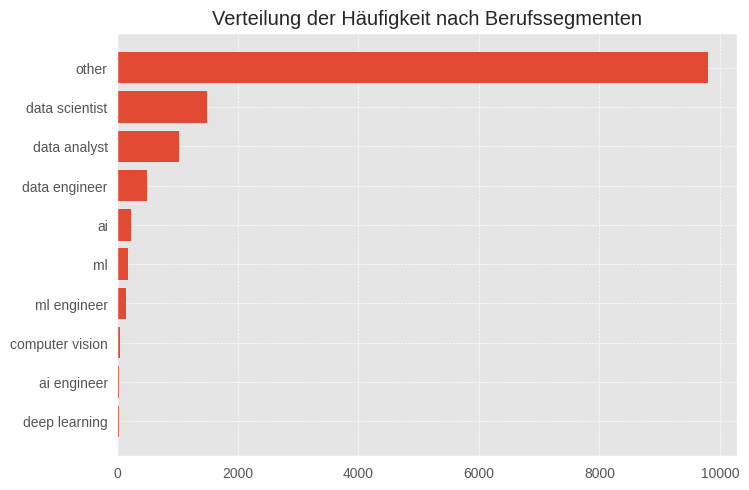

In [8]:
#Plot der Verteilung der Berufe im Datensatz
job_counts = countJobs(df)
title = "Verteilung der Häufigkeit nach Berufssegmenten"
plotBar(list(job_counts.keys()), job_counts.values(), title, barh=True)

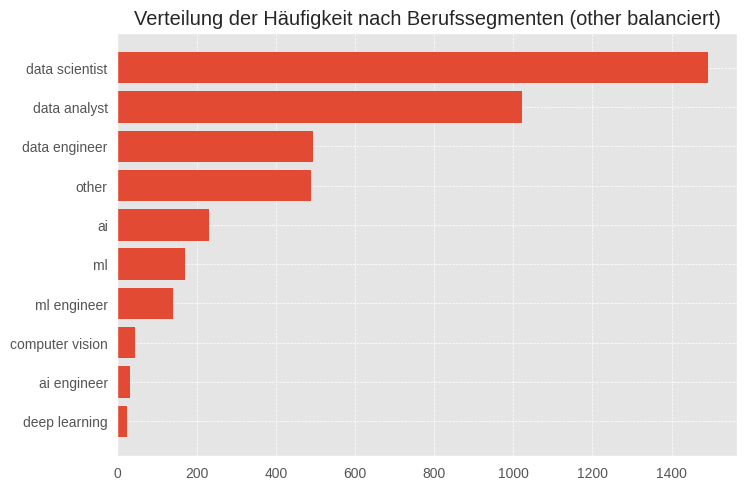

In [9]:
#Da der Datensatz unbalanciert ist, wird dieser begrenzt 
df_balanced = df.drop(df[df['other'] == 1].sample(frac=.95).index)
job_counts = countJobs(df_balanced)
#Plot des balancierten Datensatzes  
title = "Verteilung der Häufigkeit nach Berufssegmenten ( balanciert)"
plotBar(list(job_counts.keys()), job_counts.values(), title, barh=True)

**Übersetzen der Daten** <a class="anchor" id="chapter2_2"></a>

Um einen Überblick über die Verteilung der Sprachen im Datensatz zu erhalten, wird zunächst untersucht, wie oft Texte auf Englisch oder Deutsch verfasst sind

In [557]:
#Erstelle ein Dictionary zur Zählung der Anzahl an englischen und deutschen Texte
counter_lang = {'englisch': 0, 'deutsch': 0}
for text in df_balanced.link_text:
    # Überprüfe, ob der Text auf Deutsch oder Englisch ist
    if detect(text) == 'de':
        counter_lang['deutsch'] +=1
    elif detect(text) == 'en':
        counter_lang['englisch'] +=1

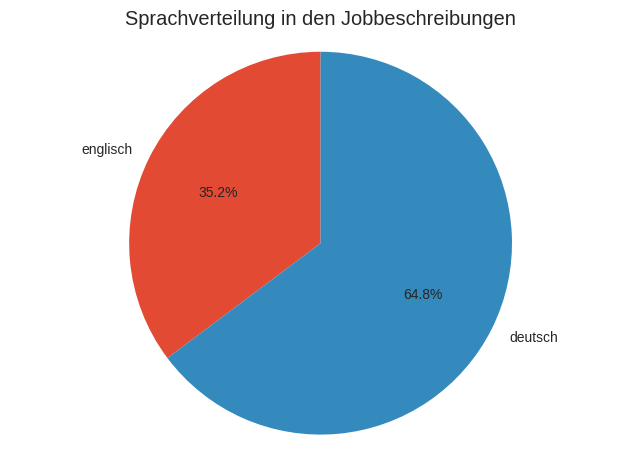

In [558]:
#Plote ein Kreisdiagramm basierend auf den Werten aus dem counter_lang Dictionary
title_lang = "Sprachverteilung in den Jobbeschreibungen"
plt.pie(counter_lang.values(), autopct='%1.1f%%', startangle=90, labels=list(counter_lang.keys()))
plt.title(title_lang)
plt.axis('equal')
plt.show()

In [ ]:
# Initialisiere den Übersetzer mit der API-URL
translator = LibreTranslateAPI("https://translate.argosopentech.com/")
def translateData(data):
    '''
    Übersetzt die Jobbeschreibungen in englische Sprache
    :param data: Datensatz mit Jobbeschreibungen
    :return: bearbeiteter Datensatz mit übersetzten Jobbeschreibungen
    '''
    # Durchlaufe jeden Datensatz in der data Tabelle
    for idx, row in data.iterrows():
        # Überprüfe, ob die Jobbeschreibung auf Deutsch ist
        if detect(row.link_text) == 'de':
            try:
                # Übersetze die Jobbeschreibung mit der translate() Funktion
                translated = translator.translate(row['link_text'], "de", "en")
                data.loc[idx,'translated'] = translated
            #Falls ein HTTP-Fehler auftritt, soll dieser aufgefangen werden
            except HTTPError as e:
                if e.code == 502:
                    print('Exeption 502 on: ' + str(idx))
                    break
        
    return data

In [ ]:
batches = 20
df_balanced["translated"] = ""
#Teilt dataframe in batches auf, übersetzt diese mit translateData Methode und speichert die Ergebnisse als csv
for batch in np.array_split(df_balanced, batches):
    assert len(batch) == len(df_balanced) / batches
    data = translateData(batch)

In [1961]:
#df_balanced.to_csv("data_translated.csv", index=False)

### Natural Language Processing <a class="anchor" id="chapter3"></a>

In [2]:
#Lade den übersetzen Datensatz
df_trans = pd.read_csv("./data_translated.csv")

In [15]:
df_trans.head(5)

link_text  ai  ai engineer  \
0  Über uns  Unsere über 30 jährige  Erfolgsgesch...   0            0   
1   Unsere über 30 jährige  Erfolgsgeschichte im ...   0            0   
2   Die intelligente  Nutzung von  Daten erlaubt ...   0            0   
3     Vollzeit, ab sofort in  Coburg, unbefristet...   0            0   
4   Die  Pro Sieben Sat.1  Group ist eines der gr...   0            0   

   computer vision  data analyst  data engineer  data scientist  \
0                0             0              0               1   
1                0             0              0               1   
2                0             0              0               0   
3                0             0              0               0   
4                0             0              0               1   

   deep learning  ml  ml engineer  other  \
0              0   0            1      0   
1              0   0            0      0   
2              0   0            1      0   
3              0   0            1      0   
4              0   0            0      0   

                                          translated  
0  About us our over 30 years of success in the s...  
1   Our over 30 years of success story in the sof...  
2   The intelligent use of data allows us to crea...  
3     Full -time, from now on in Coburg, the inte...  
4   The Pro Sieben Sat.1 Group is one of the larg...

**Stopwörter entfernen** <a class="anchor" id="chapter3_1"></a>

In [3]:
#Diese Stoppwörter werden zu den bereits vorhandenen Stoppwörtern aus nltk-Bibliothek hinzugefügt 
#und sollen im weiteren Verlauf bei der Verarbeitung der Jobbeschreibungen ausgeschlossen werden, 
#um die Relevanz der Informationen zu erhöhen
job_stopwords = ["engineer", "u", "scientist", "analyst", "break", "mindfulness", "courses", "pilates", "joint", 
                 "lunch", "party", "seasonal", "action", "event", "project", "hobby", "group", "coitry", 
                 "foundation", "knowledge", "cafe", "board", "game", "round", "sport", "fruit", 
                 "basket", "lunch", "menu", "coffee", "tea", "drink", "free", "charge", "look", "forward", 
                 "online", "application", "care", "careful","ice", "cream", "casino", "meal", "yoga", "restaurant",
                 "workout", "gender", "identity", "contact", "within", "many", "well", "use", "man", "form", 
                 "salutation","birthday", "vacation", "christmas", "lgbt", "roof", "terrace", "little", 
                 "table", "tennis", "plate", "xing", "linkedin", "account", 'eg', 'team', 'develip', 'development', 
                 'customer', 'company', 'team', 'solution', 'support', 'work', 'product', 'service', 'including', 'etc',
                 'employee', 'offer', 'service', 'new']
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(job_stopwords)

**Tokenizer und Lemmatizer** <a class="anchor" id="chapter3_2"></a>

In [4]:
#Bereitet die Daten vor, indem er sie in Tokens aufteilt und bereinigt
df_trans["tokens"]=''
lemmatizer = nltk.wordnet.WordNetLemmatizer()
reg = re.compile('[' +re.escape(string.punctuation)+ '\\r\\t\\n]')
for idx, row in df_trans.iterrows():
    #Übersetzten Jobbeschreibungen in Kleinbuchstaben konvertieren
    text = row.translated.lower()
    #Zeichen, die Teil des regulären Ausdrucks sind, entfernen
    text = reg.sub("", text)
    #Lemmatizer anwenden, um Wortformen in ihre Grundform zu konvertieren und entferne Stopwörter
    cleaned_stopwords = ' '.join(lemmatizer.lemmatize(word) for word in text.strip().split(' ') if lemmatizer.lemmatize(word).lower() not in stop_words)
    #Jeder Satz wird tokenisiert
    sentence = nltk.sent_tokenize(cleaned_stopwords)
    tokens = [nltk.word_tokenize(sent) for sent in sentence]
    for token in tokens[0]:
        #Token in die "tokens"-Spalte des Datensatzes einfügen und mit Komma separieren
        df_trans.loc[idx,'tokens'] += token + ","

In [30]:
def cleanData(datalist, keyword='', count = False):
    """
    bereinigt eine Liste von Texten und gibt eine Liste von Sätzen zurück, die das angegebene Wort enthalten
    :param datalist: Liste der Texte, die bereinigt werden sollen
    :param keyword: Wort, nach dem die Sätze gefiltert werden sollen
    :return: Liste der bereinigten Sätze, die das angegebene Wort enthalten
    """
    cleaned_list = []
    lemmatizer = nltk.wordnet.WordNetLemmatizer()
    reg = re.compile('[' +re.escape(string.punctuation) + '\\r\\t\\n]')
    for text in datalist:
        #Konvertiere den Text in Kleinbuchstaben und bereinige die Stopwörter
        text = text.lower()
        cleaned_stopwords = ' '.join(lemmatizer.lemmatize(word) for word in text.strip().split(' ') if lemmatizer.lemmatize(word.lower()) not in stop_words)
        sentence = nltk.sent_tokenize(cleaned_stopwords)
        #Filtere nach dem angegebenen Wort
        if keyword != '':
            for sent in sentence:
                if keyword in sent:
                    sentence = reg.sub("", sent)
                    cleaned_list.append(sentence)
        #Wenn kein Keyword vorhanden, füge alle Sätze in die Liste
        else:
            cleaned_list.append(sentence)
    #Extrahiere mehrere Listen mit Sätzen zu einer Liste
    new_list = list(itertools.chain(*cleaned_list))
    #Wenn count-Parameter aktiv ist, gib die bereinigte Liste zurück
    if count:
        return new_list
    #Tokenisiere die bereinigten Sätze und gib eine Liste von Wörtern zurück
    else:
        return [word_tokenize(reg.sub("", sentence)) for sentence in new_list]

**Themen Übersicht** <a class="anchor" id="chapter3_3"></a>

In [31]:
def topicDict(df):
    """
    Erstellt ein Dictionary, das die Berufsfelder aus dem Dataframe als key und die dazugehörige
    Jobbeschreibung als value enthält
    :param df: Dataframe mit Berufen und deren Beschreibungen
    :return: Dictionary mit Berufen und deren Beschreibungen
    """
    joblist = list(df[df.columns.difference(["tokens", "translated", 'link_text'])])
    counter_list = {job: 0 for job in joblist}
    for job in counter_list:
        #Für jeden Beruf die Beschreibungen filtern und zuordnen
        counter_list[job] = cleanData(df[df[job]==1].translated.to_list())
    #Dictionary sortiert zurückgeben
    return dict(sorted(counter_list.items(), key=lambda item: item[1]))

In [36]:
job_topics = topicDict(df_trans)

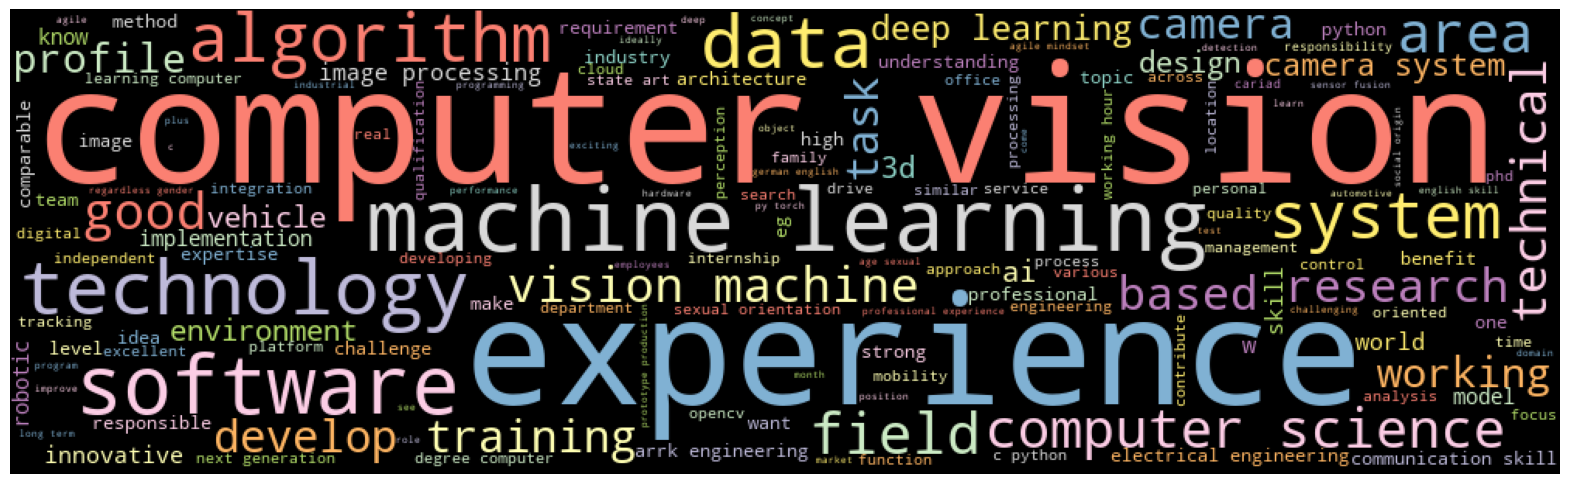

In [38]:
#Erstellt eine Wortwolke aus den Beschreibungen, für eine bessere Einordnung der Themen zu den jeweiligen Job,
#der vorher mit der topicDict-Methode gefiltert wurde
text = " ".join(list(itertools.chain(*job_topics['computer vision'])))
plt.figure(figsize=(20,10))
cloud = WordCloud(width= 1000, height=300,background_color="black", max_words= 150, colormap='Set3').generate(text)
plt.imshow(cloud)
plt.axis("off")
plt.show()

**Neue Anforderungen kreieren** <a class="anchor" id="chapter3_4"></a>

In [39]:
#Liste mit Anforderungen für Berufe im Computer Science Bereich, gefiltert mit der Clustering-Methode und der 
#topicDict-Funktion
requirement = { 'languages' :      ['python',' r ','java',' c ','scala', 'julia', 'javascript', 'sql', 'php', 'ruby'],
                'frameworks' :     ['matlab','pandas','numpy','scipy','scikit','tensorflow','keras','kera','pytorch',
                                    'theano','seaborn', 'opencv', 'pcl', 'opencl','scikitlearn',
                                    'mxnet', 'sklearn', 'nltk','flask'],
               'devops':          ['git','jupyter', 'docker','kubernetes'],
               'bigdata':         ['aws','mongodb','databricks', 'sap', 'oracle','caffe','spark','dask','hadoop','storm',
                                   'kafka','flink','cassandra','hbase','hive','pig','mahout','azure', 'nosql',
                                   'mongodb', 'mysql', 'django','sagemaker', 'node'],
               'education' :      ['promotion', 'master', 'bachelor', 'diplom', 'msc', 'bsc', 'phd','doctorate', 
                                   'post doc'],
               'degree':          ['mathematics', 'physics', 'computer science', 'statistics','informatics',
                                   'business administration', 'business administration','social sciences',  
                                   'psychology', 'electrical engineering', 'business informatics', 'artificial intelligence',
                                   'computational linguistics','natural sciences', 'robotics', 'biophysics', 'business informatics'],
               'skills' :         ['image processing', 'computer vision', 'robotics', 'deep learning', 'nlp', 'natural language',
                                   '3d', 'presentation','cleaning', 'scientific publications', 'software engineering', 
                                   'database', 'image regression','research', 'regression', 'text analytics', 
                                  'sensors', 'cloud', 'devops', 'ms office', 'object detection', 'big data', 'neuronal networks',
                                  'data mining', 'power point', 'cameras', 'radars', 'lasers', 'software development', 'analytics',
                                  'data visualization', 'linguistic data', 'cloud native', 'web technologies','ad hoc',
                                  'ad hoc analysis', 'visualization', 'reinforcment', 'unsupervised', 'supervised', 'optimization', 
                                   'algorithm','statistical', 'analysis visualization', 'clustering', 'cluster', 'advanced analytics', 'digitization',
                                  'data quality', 'classification', 'prediction', 'analysis visualization', 'report dashboard', 'reporting',
                                  'microsoft office', 'excel', 'data engineering', 'methodology', 'data pipeline', 'segmentation',
                                  'pipelines', 'transformation', 'etl', 'architecture','data quality','ocr', 'automation',
                                  'detection', 'autonomous', 'recognition', 'speech recognition', 'labeling', 'topology']
              }

In [40]:
def addRequirements(dataframe):
    '''
    Fügt Anforderungen auf der obigen Liste zu den jeweiligen Berufen hinzu, indem es in 
    den Beschreibungen danach filtert
    :param df: Dataframe mit Berufen und deren Beschreibungen
    :return: Dataframe mit Berufen und gefilterten Keywörtern auf dem requirement-Dictionary
    '''
    dataframe['filtered_reqs']=''
    for idx, row in dataframe.iterrows():
        #Den Text in Kleinbuchstaben konvertieren
        text = row.translated.lower()
        #Über jede Anforderung in der Liste iterieren
        for reqs in requirement:
            #Über jedes Schlüsselwort iterieren
                for keyword in requirement[reqs]:
                    #Wenn der key im konvertierten Text gefunden ist wird es im Datensatz gespeichert 
                    if re.search(re.escape(keyword), text):
                        dataframe.loc[idx,'filtered_reqs'] += keyword + ','
            
    return dataframe                

In [41]:
filtered_df = addRequirements(df_trans)

### Clusteanalyse <a class="anchor" id="chapter4"></a>

#### Unbalancierte Daten <a class="anchor" id="chapter4_1"></a>

In [5]:
df_trans = df_trans.drop('link_text', axis=1)

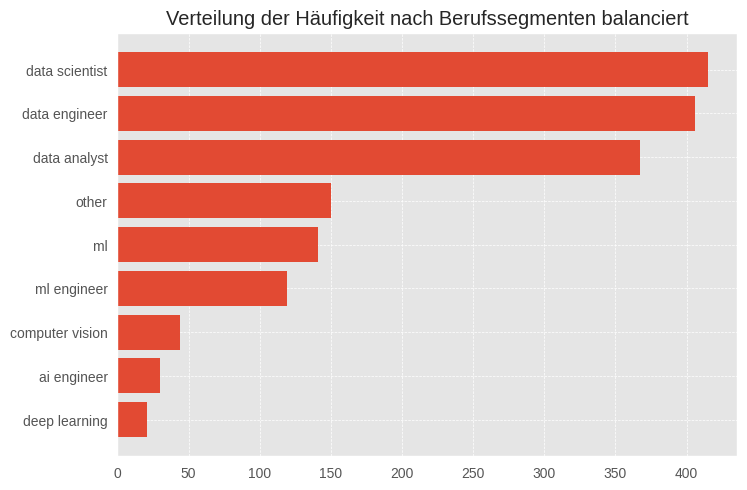

In [324]:
#Balancierten Datensatz mit Jobbeschreibungen erstellen 
balance_ds = df_trans.drop(df_trans[df_trans['data scientist'] == 1].sample(n=len(df_trans[df_trans['data scientist'] == 1])-450, random_state=42).index)
balance_da = balance_ds.drop(balance_ds[balance_ds['data analyst'] == 1].sample(n=len(df_trans[df_trans['data analyst'] == 1])-450 , random_state=42).index)
balance_de = balance_da.drop(balance_da[balance_da['data engineer'] == 1].sample(n=len(df_trans[df_trans['data engineer'] == 1])-450  , random_state=42).index)
balance_oth = balance_de.drop(balance_de[balance_de['other'] == 1].sample(n=len(df_trans[df_trans['other'] == 1])-150  , random_state=42).index)
balanced = countJobs(balance_oth[balance_oth.columns.difference(["tokens", "translated", "link_text"])])
title = "Verteilung der Häufigkeit nach Berufssegmenten balanciert"
plotBar(list(balanced.keys()), balanced.values(), title, barh=True)

**KMean Clustering** <a class="anchor" id="chapter4_2"></a>

In [52]:
#Erstellt eine Pipeline-Methode, mit den Vectorizer, Dimensionsreduzier und den Klassifizierer 
def createPipe(clf, dim):
    return Pipeline([('vct', CountVectorizer()), ('svd', TruncatedSVD(dim)),('clf', clf)])

In [60]:
#Legt die Dimension für die Dimensionsreduktion fest und definiert den X_train
dim = 3
X_train = filtered_df.filtered_reqs

In [53]:
#Initialisiert des KMeans-Modells, fügt diesen in die Pipeline hinzu, transformiert die Dimension
#und berechnet die Dimension
kms = KMeans(n_clusters=4, n_init=10, random_state=1)
pipe = createPipe(kms, 3)
X = pipe.fit_transform(X_train)
y_pred = pipe.predict(X_train)

In [54]:
#Iteriert über jeden Datenpunkt und ordnet Jobtyp als Klasse zu
true_lab = []
for i in range(len(y_pred)):
    true_lab.append(df_trans.columns[df_trans.iloc[i]==1].tolist())

In [55]:
#Erstellt ein Dictionary mit den vorhergesagten Klassen, den tatsächlichen Klassen und dem dazugehörigen Text
df_dict = {'labels':y_pred, "tokens": X_train, 'true_labels': true_lab}
df_clf = pd.DataFrame(df_dict)

In [56]:
#Berechnet den Silhouette Score
print(f'Silhouette Score: {silhouette_score(X, df_dict["labels"])}')

Silhouette Score: 0.36249359928265923


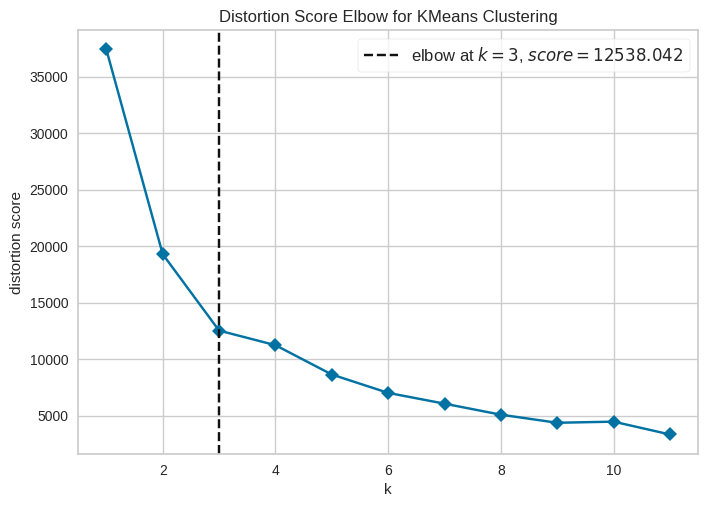

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [46]:
#Visualisiert die Elbow-Methode, um die bestmögliche Klassenanzahl festzustellen 
visualizer = KElbowVisualizer(KMeans(n_init='auto'), k=(1,12), timings=False)
visualizer.fit(X)
visualizer.show()

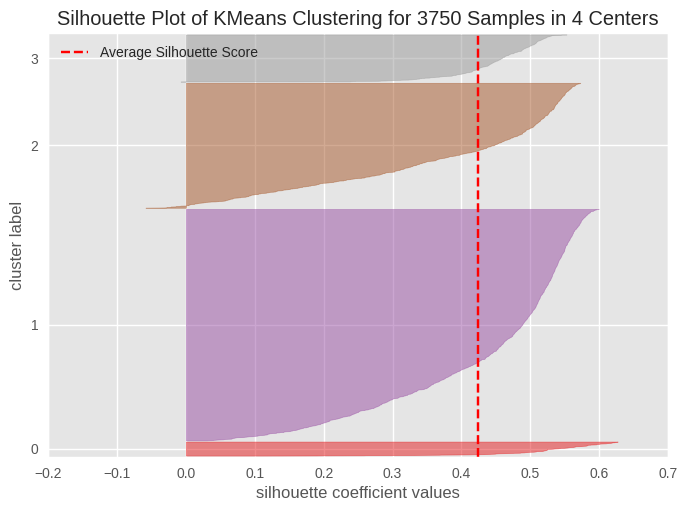

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 3750 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [214]:
#Visualisiert die Silhouetten, um einen Überblick über die Ähnlichkeite der Cluster zu erhalten
visualizer = SilhouetteVisualizer(KMeans(n_clusters=4, n_init='auto'))
visualizer.fit(X)
visualizer.show()      

In [59]:
#Pipeline für die Dimensionenreduktion mithilfe des t-SNE, um die Cluster in 2D zu visualisieren zu können
pipe_dim = createPipe(TSNE(n_components=2), dim)
tsne = pipe_dim.fit_transform(X_train)
df_tsne = pd.DataFrame(tsne, columns=['tSNE_1','tSNE_2'])

In [26]:
def plotScatter(tsne_df, labels):
    '''
    Visualisierung des Clusters als Streudiagramm
    '''
    plt.figure(figsize=(13,7))
    sns.scatterplot(x='tSNE_1',y='tSNE_2', data=df_tsne, hue=labels,  palette='muted', alpha=0.8)
    plt.show()

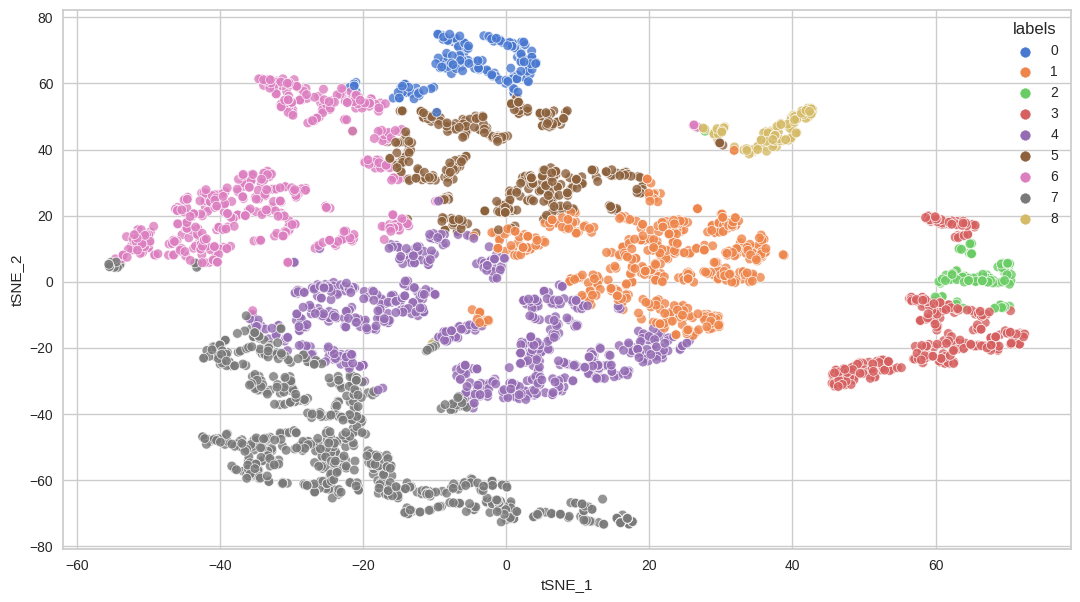

In [48]:
plotScatter(df_tsne,df_clf['labels'])

In [217]:
#Die dazugehörigen wahren Klassen
collections.Counter([tuple(x) for x in df_clf[df_clf['labels']==3]['true_labels']])

Counter({('data analyst',): 54,
         ('data scientist',): 142,
         ('data engineer',): 115,
         ('data scientist', 'ml engineer'): 3,
         ('ai', 'data engineer'): 1,
         ('data analyst', 'data engineer'): 7,
         ('ai', 'data analyst', 'data scientist'): 2,
         ('data engineer', 'ml'): 1,
         ('data analyst', 'data scientist'): 7,
         ('ai', 'data scientist'): 1,
         ('data analyst', 'data engineer', 'data scientist'): 4,
         ('other',): 2,
         ('data engineer', 'data scientist'): 9,
         ('data scientist', 'ml'): 4,
         ('data engineer', 'ml engineer'): 1,
         ('ai', 'data analyst'): 1,
         ('ai engineer',): 1,
         ('ai',): 2,
         ('ml engineer',): 9,
         ('computer vision', 'data scientist'): 1})

In [25]:
def plotWordCloud(df,label_col,label):
    '''
    Funktion zur Visualisierung der WordClouds für einen besseren Überblick über die Themen der jeweiligen Berufe 
    '''
    plt.figure(figsize=(20,10))
    text = ' '.join(df[df[label_col]==label]['tokens'].values)
    wc = WordCloud(width= 1000, height=300,background_color="black", max_words= 150, colormap='Set3').generate(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

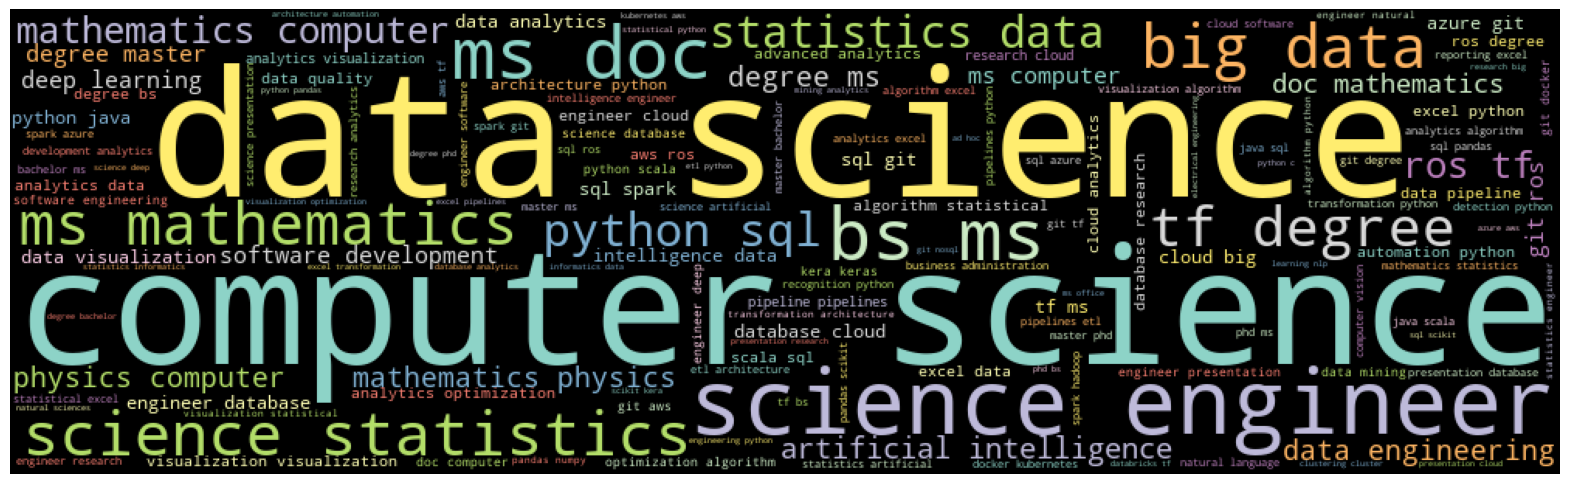

In [220]:
plotWordCloud(df_clf,'labels',1)

**Agglomerative Clustering** <a class="anchor" id="chapter4_3"></a>

In [69]:
#Hierarchisches Clustering mit AgglomerativeClustering
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train)
svd = TruncatedSVD(3)
X = svd.fit_transform(X)
agg = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
agg.fit(X)
df_clf['labels_agg'] =  agg.labels_
#Berechnet den Silhouette-Score, um die Qualität der Clusterzuordnung zu bewerten
print(silhouette_score(X, agg.labels_))

0.3307761189444762


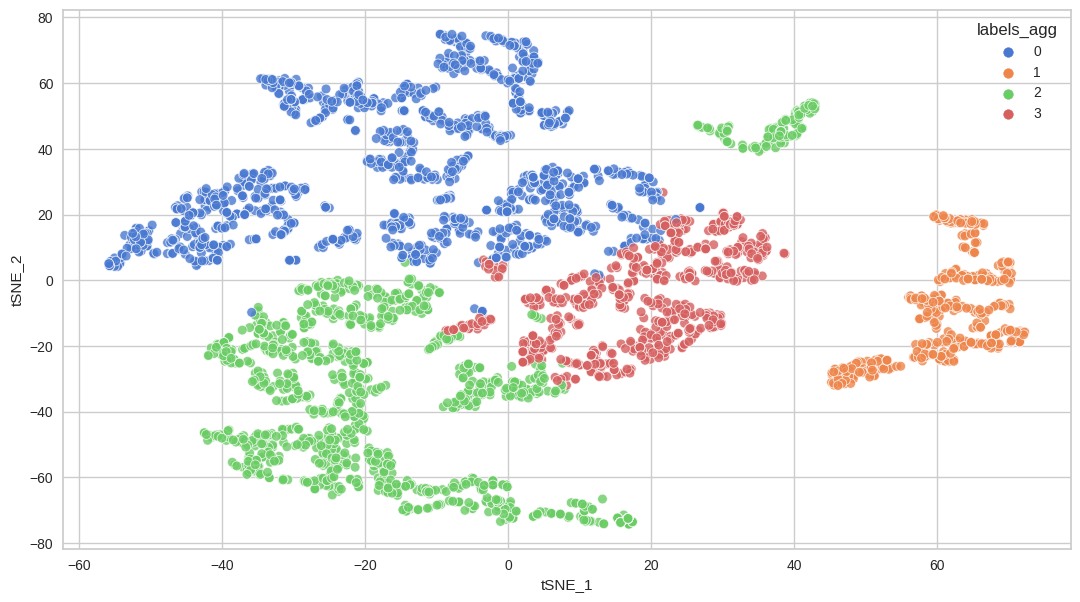

In [71]:
#Visualisierung des AgglomerativeClustering als Streudiagramm 
plotScatter(df_tsne,df_clf['labels_agg'])

In [70]:
#Wahre Klassen
collections.Counter([tuple(x) for x in df_clf[df_clf['labels_agg']==3]['true_labels']])

Counter({('data scientist',): 265,
         ('ai', 'data scientist'): 19,
         ('ai',): 50,
         ('deep learning',): 11,
         ('computer vision',): 20,
         ('ai', 'data analyst', 'ml'): 1,
         ('data analyst',): 92,
         ('ai', 'computer vision'): 1,
         ('data scientist', 'ml'): 12,
         ('ml engineer',): 37,
         ('computer vision', 'ml'): 7,
         ('other',): 35,
         ('ai engineer',): 11,
         ('data engineer',): 16,
         ('data analyst', 'data scientist'): 22,
         ('ml',): 52,
         ('data scientist', 'ml engineer'): 2,
         ('ai', 'data scientist', 'ml'): 3,
         ('ai', 'ml'): 6,
         ('ai engineer', 'computer vision'): 1,
         ('data analyst', 'data engineer'): 2,
         ('ai', 'data engineer'): 1,
         ('ai', 'ml engineer'): 4,
         ('deep learning', 'ml'): 1,
         ('data analyst', 'ml'): 1,
         ('ai', 'computer vision', 'ml'): 1,
         ('computer vision', 'deep learning'): 1,
  

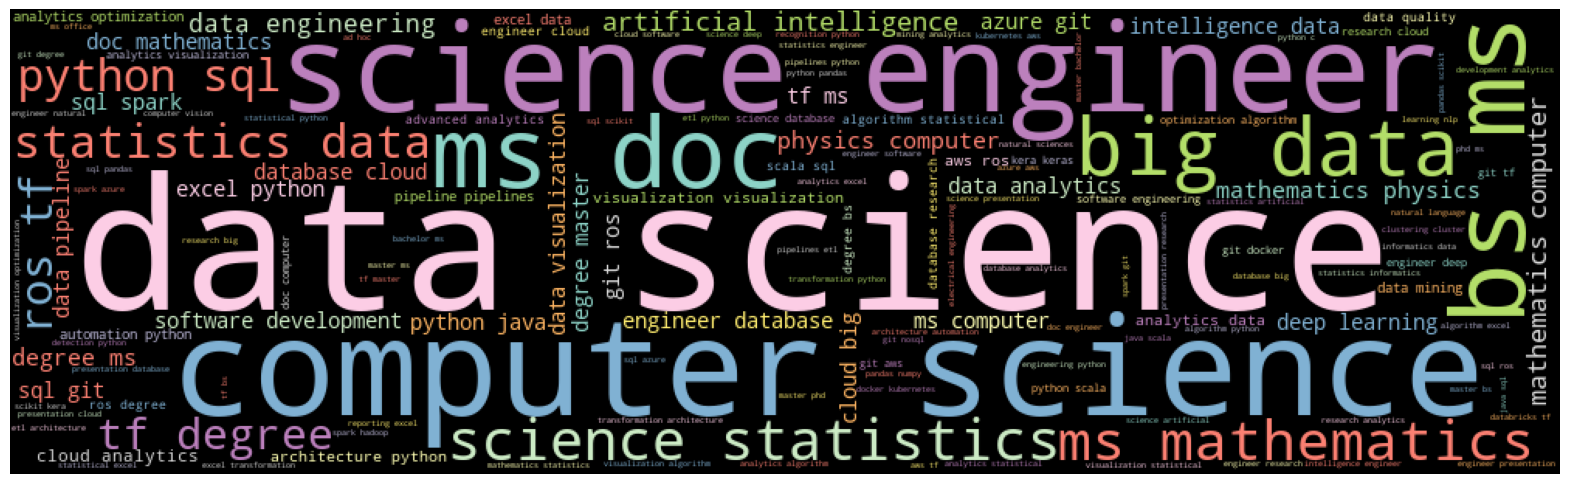

In [234]:
plotWordCloud(df_clf,'labels_agg',0)

### Analysis der Anforderungen <a class="anchor" id="chapter5"></a>

In [73]:
def countRequirements(datalist, keywordlist, keyword=''):
    '''
    Dient zur Datenanalyse. Die Methode zählt die im Text vorhandenen Keyworte um eine Statistik zu erheben
    :param datalist: Dataframe mit Berufen und deren Beschreibungen
    :param keywordlist: Liste mit den Keyworten
    :param keyword: Word,nach dem der Text begrenz werden soll für Präzision 
    :return: Dataframe mit Berufen und gefilterten Keywörtern auf dem requirement-Dictionary
    '''
    # cleanData wird aufgerufen, um die Datenliste zu bereinigen und nach optionalen Keywörtern zu filtern
    search_data =  cleanData(datalist, keyword, count = True)
    counter_list = {keyword.lower(): 0 for keyword in keywordlist}
    for text in search_data:
        for keyword in keywordlist:
            # Checkt ob das Keyword in dem Text gefunden wurde
            if re.search(re.escape(keyword), text):
                #Wenn ja wird der Counter erhöht 
                counter_list[keyword] += 1
    #Liste der Keywords sortiert als Dictionary zurückgeben
    return dict(sorted(counter_list.items(), key=lambda x: x[1], reverse=True))

In [74]:
for reqs in requirement.keys():
    #Erstellt für jede Anforderung ein Dictionary mit den Berufen und den jeweiligen Anforderungen
    globals()['%s_count' % reqs] = {job: 0 for job in job_topics.keys()}
    for job in job_topics.keys():
        topic = df_trans[df_trans[job]==1].translated.to_list()
        globals()['%s_count' % reqs][job] = countRequirements(topic, requirement[reqs])

In [386]:
#Erstellt ein Dataframe 
def createDF(req_dict):
    df = pd.DataFrame(data=[req_dict['data scientist'], 
                            req_dict['data analyst'],
                            req_dict['data engineer'],
                            req_dict['ai'],
                            req_dict['ai engineer'],
                            req_dict['ml'],
                            req_dict['ml engineer'],
                            req_dict['computer vision'],
                            req_dict['deep learning'],
                            req_dict['other']
                           ])
    return df

In [195]:
#Erstellt für jede Anfprderung einen Dataframe aus den Dictionarys 
lngs = createDF(languages_count)
fwks = createDF(frameworks_count)
dps = createDF(devops_count)
bgdt = createDF(bigdata_count)
edct =createDF(education_count)
skls =createDF(skills_count)
dgr =createDF(degree_count)

In [288]:
#Wenn Wörter zwar anders geschrieben sind, aber die gleiche Bedeutung haben, werden diese zusammengefügt
#colum_names = ['kera', 'keras']
#dgr['keras'] = dgr[colum_names].sum(axis=1)
#dgr = dgr.drop('data science', axis=1)

In [292]:
#Die Daten werden für die Diagramme sortiert
def sortForPlot(df, idx):
    sorted_dc = dict(sorted([x for x in df.iloc[idx].to_dict().items() if x[1] != 0], key=lambda x: x[1], reverse=True))
    return [*sorted_dc.keys()], [*sorted_dc.values()]

**Data Science** <a class="anchor" id="chapter5_1"></a>

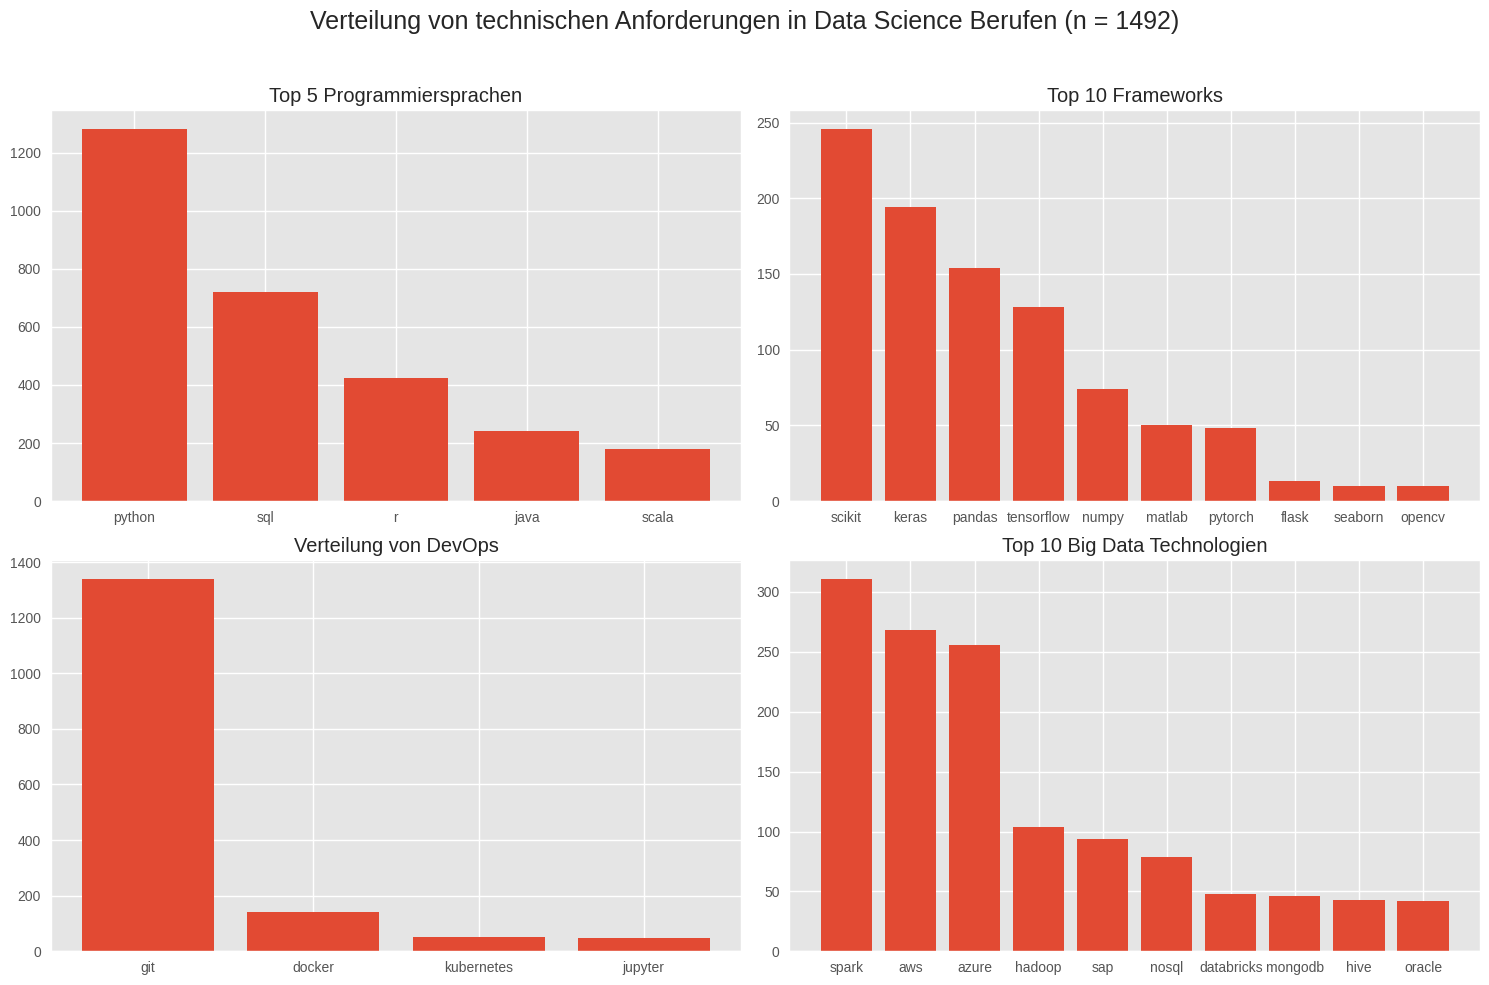

In [280]:
fig, (ax1, ax2) = plt.subplots(2, 2, constrained_layout=False, figsize=(15,10))
fig.suptitle(f"Verteilung von technischen Anforderungen in Data Science Berufen (n = {job_counts['data scientist']})", 
             fontsize=18)

ax1[0].bar(sortForPlot(lngs, 0)[0][:5],sortForPlot(lngs, 0)[1][:5])
ax1[0].set_title('Top 5 Programmiersprachen')

ax1[1].bar(sortForPlot(fwks, 0)[0][:10],sortForPlot(fwks, 0)[1][:10])
ax1[1].set_title('Top 10 Frameworks')

ax2[0].bar(sortForPlot(dps, 0)[0],sortForPlot(dps, 0)[1])
ax2[0].set_title('Verteilung von DevOps')

ax2[1].bar(sortForPlot(bgdt, 0)[0][:10],sortForPlot(bgdt, 0)[1][:10])
ax2[1].set_title('Top 10 Big Data Technologien')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

Text(0.5, 1.0, 'akademischer Grad')

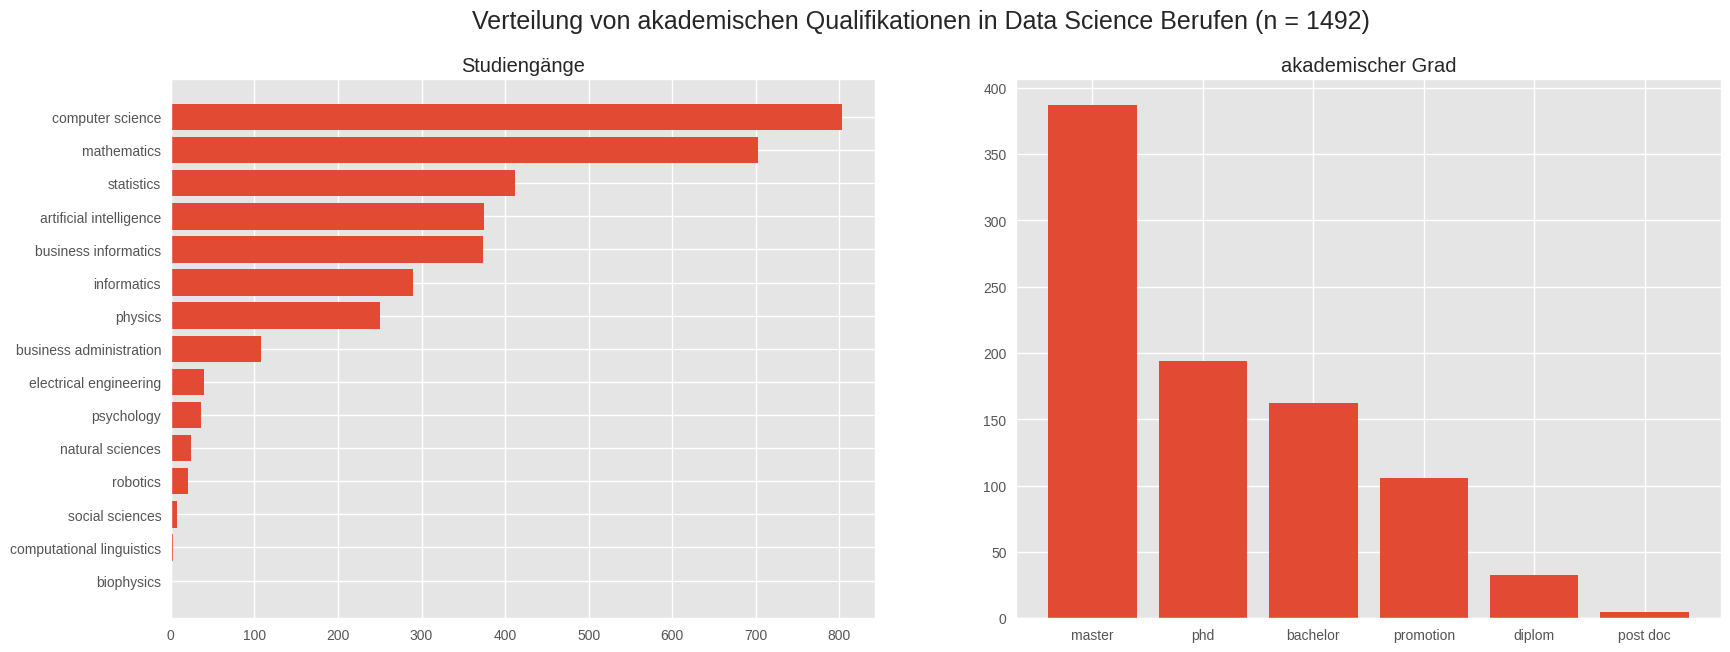

In [294]:
fig, ax = plt.subplots(1, 2, constrained_layout=False, figsize=(20,7))
fig.suptitle(f"Verteilung von akademischen Qualifikationen in Data Science Berufen (n = {job_counts['data scientist']})", 
             fontsize=18)
ax[0].barh(sortForPlot(dgr, 0)[0],sortForPlot(dgr, 0)[1])
ax[0].invert_yaxis()
ax[0].set_title('Studiengänge')

ax[1].bar(sortForPlot(edct, 0)[0],sortForPlot(edct, 0)[1])
ax[1].set_title('akademischer Grad')

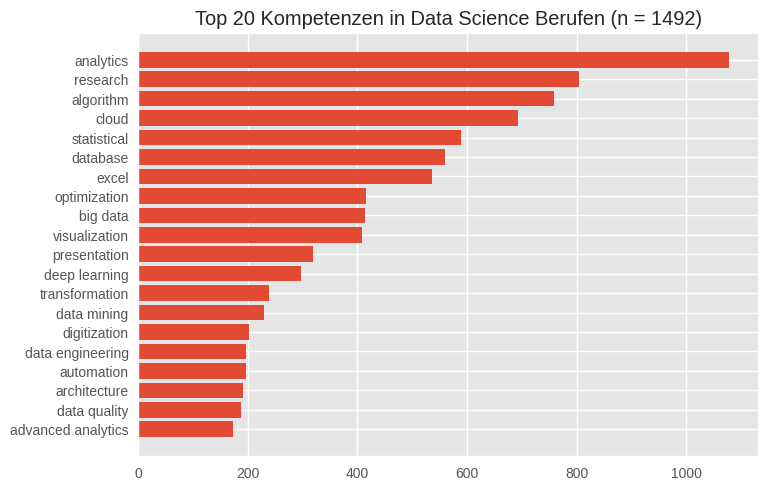

In [262]:
plt.barh(sortForPlot(skls, 0)[0][:20],sortForPlot(skls, 0)[1][:20])

plt.gca().invert_yaxis()
plt.title(f'Top 20 Kompetenzen in Data Science Berufen (n = {job_counts["data scientist"]})')
plt.show()

**Data Analyst** <a class="anchor" id="chapter5_2"></a>

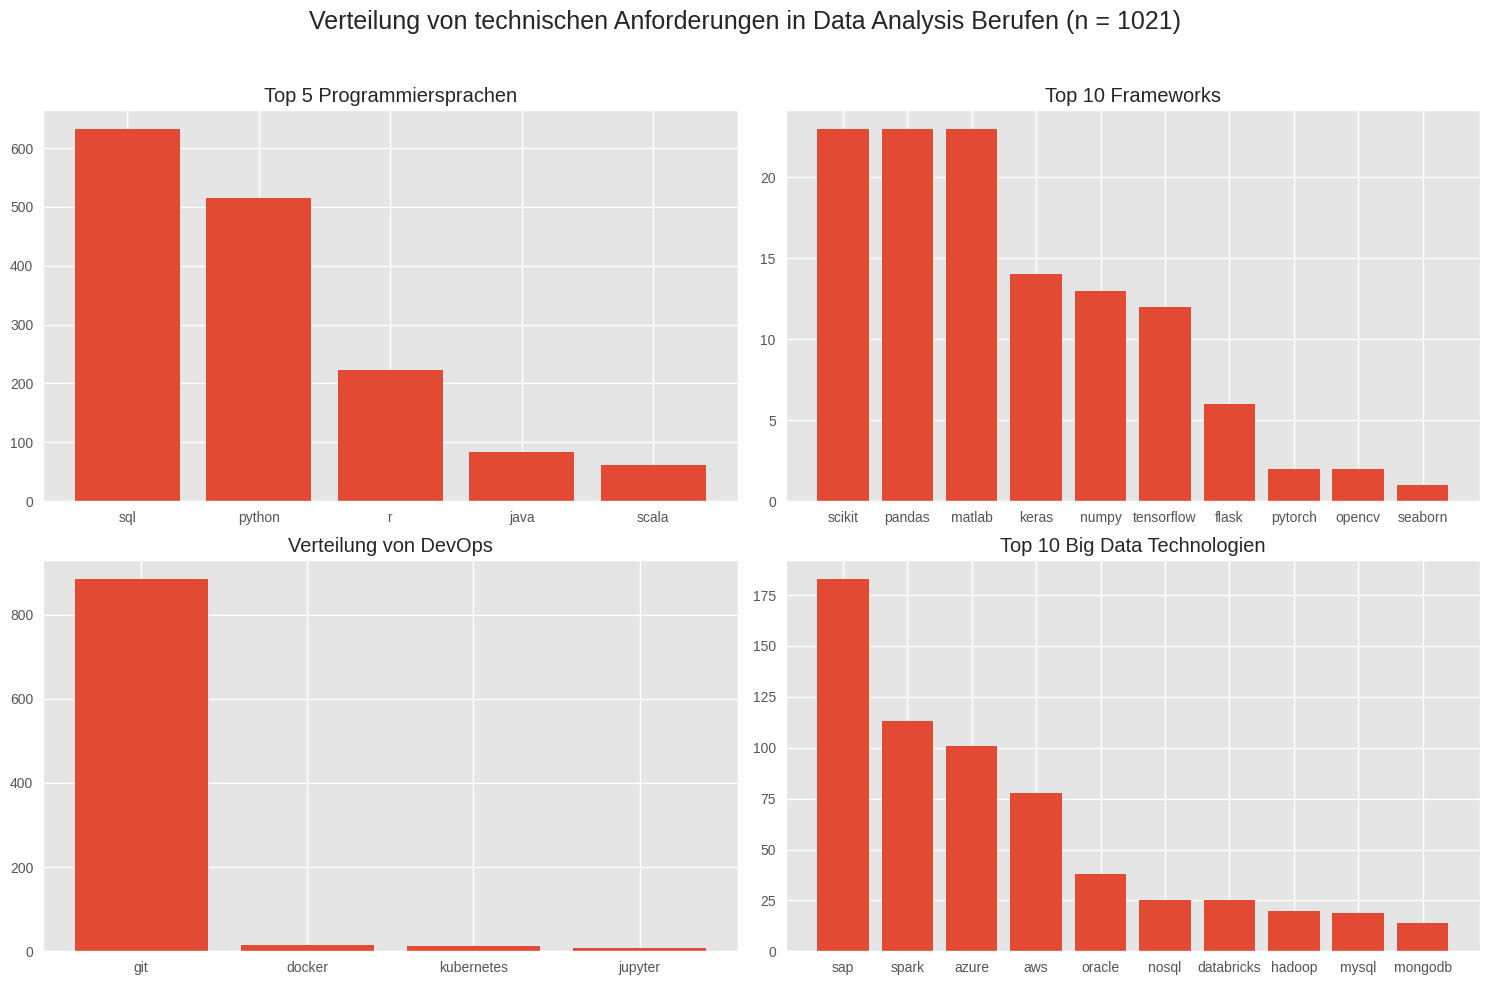

In [301]:
fig, (ax1, ax2) = plt.subplots(2, 2, constrained_layout=False, figsize=(15,10))
fig.suptitle(f"Verteilung von technischen Anforderungen in Data Analysis Berufen (n = {job_counts['data analyst']})", 
             fontsize=18)

ax1[0].bar(sortForPlot(lngs, 1)[0][:5],sortForPlot(lngs, 1)[1][:5])
ax1[0].set_title('Top 5 Programmiersprachen')

ax1[1].bar(sortForPlot(fwks, 1)[0][:10],sortForPlot(fwks, 1)[1][:10])
ax1[1].set_title('Top 10 Frameworks')

ax2[0].bar(sortForPlot(dps, 1)[0],sortForPlot(dps, 1)[1])
ax2[0].set_title('Verteilung von DevOps')

ax2[1].bar(sortForPlot(bgdt, 1)[0][:10],sortForPlot(bgdt, 1)[1][:10])
ax2[1].set_title('Top 10 Big Data Technologien')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

Text(0.5, 1.0, 'akademischer Grad')

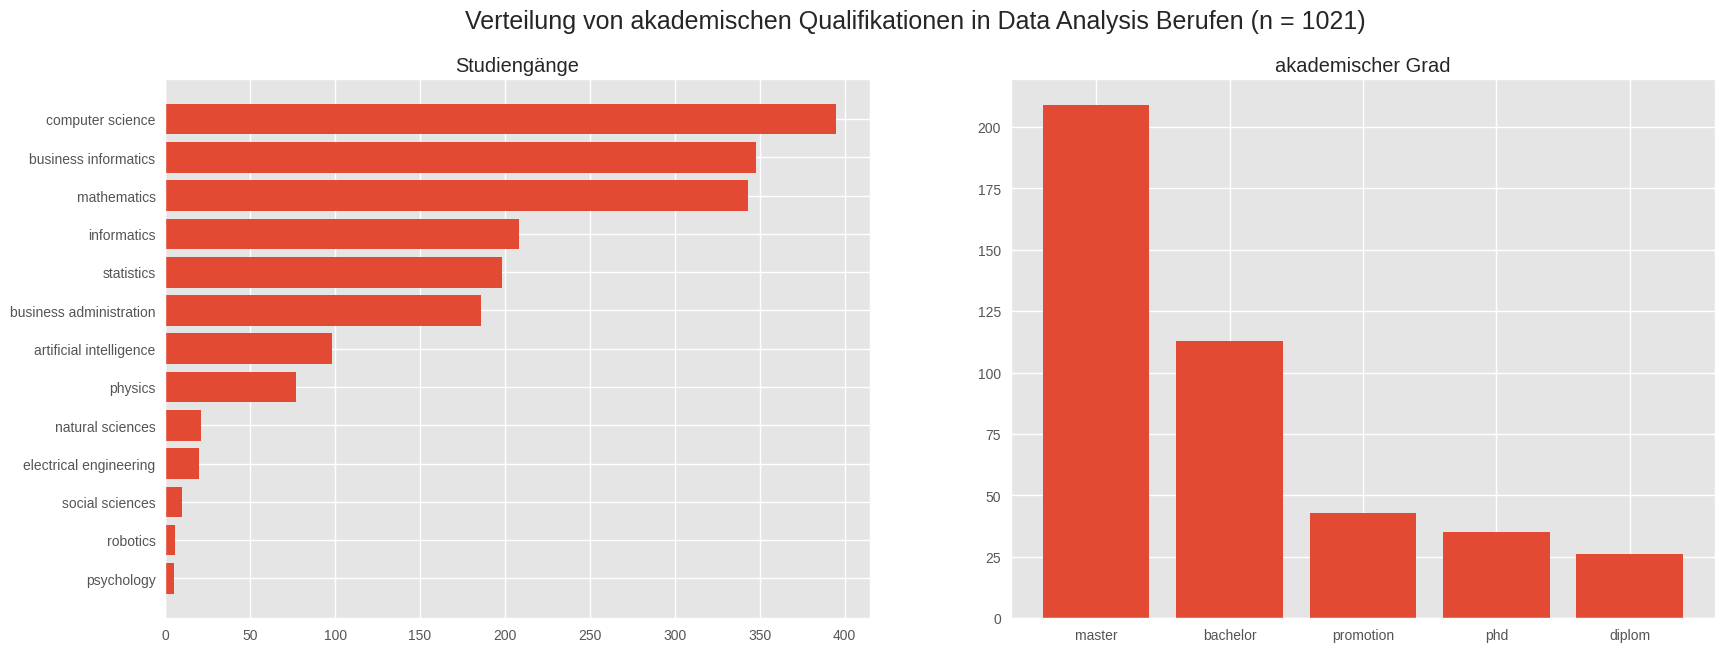

In [498]:
fig, ax = plt.subplots(1, 2, constrained_layout=False, figsize=(20,7))
fig.suptitle(f"Verteilung von akademischen Qualifikationen in Data Analysis Berufen (n = {job_counts['data analyst']})", 
             fontsize=18)
ax[0].barh(sortForPlot(dgr, 1)[0],sortForPlot(dgr, 1)[1])
ax[0].invert_yaxis()
ax[0].set_title('Studiengänge')

ax[1].bar(sortForPlot(edct, 1)[0],sortForPlot(edct, 1)[1])
ax[1].set_title('akademischer Grad')

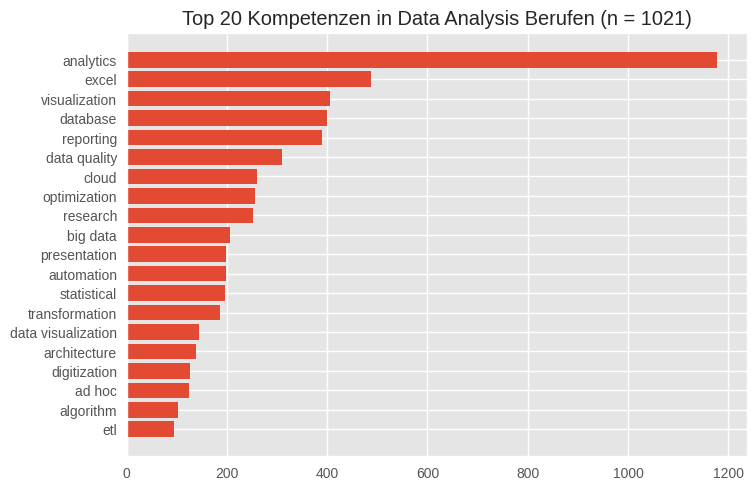

In [299]:
plt.barh(sortForPlot(skls, 1)[0][:20],sortForPlot(skls, 1)[1][:20])

plt.gca().invert_yaxis()
plt.title(f"Top 20 Kompetenzen in Data Analysis Berufen (n = {job_counts['data analyst']})") 
plt.show()

**Data Engineer** <a class="anchor" id="chapter5_3"></a>

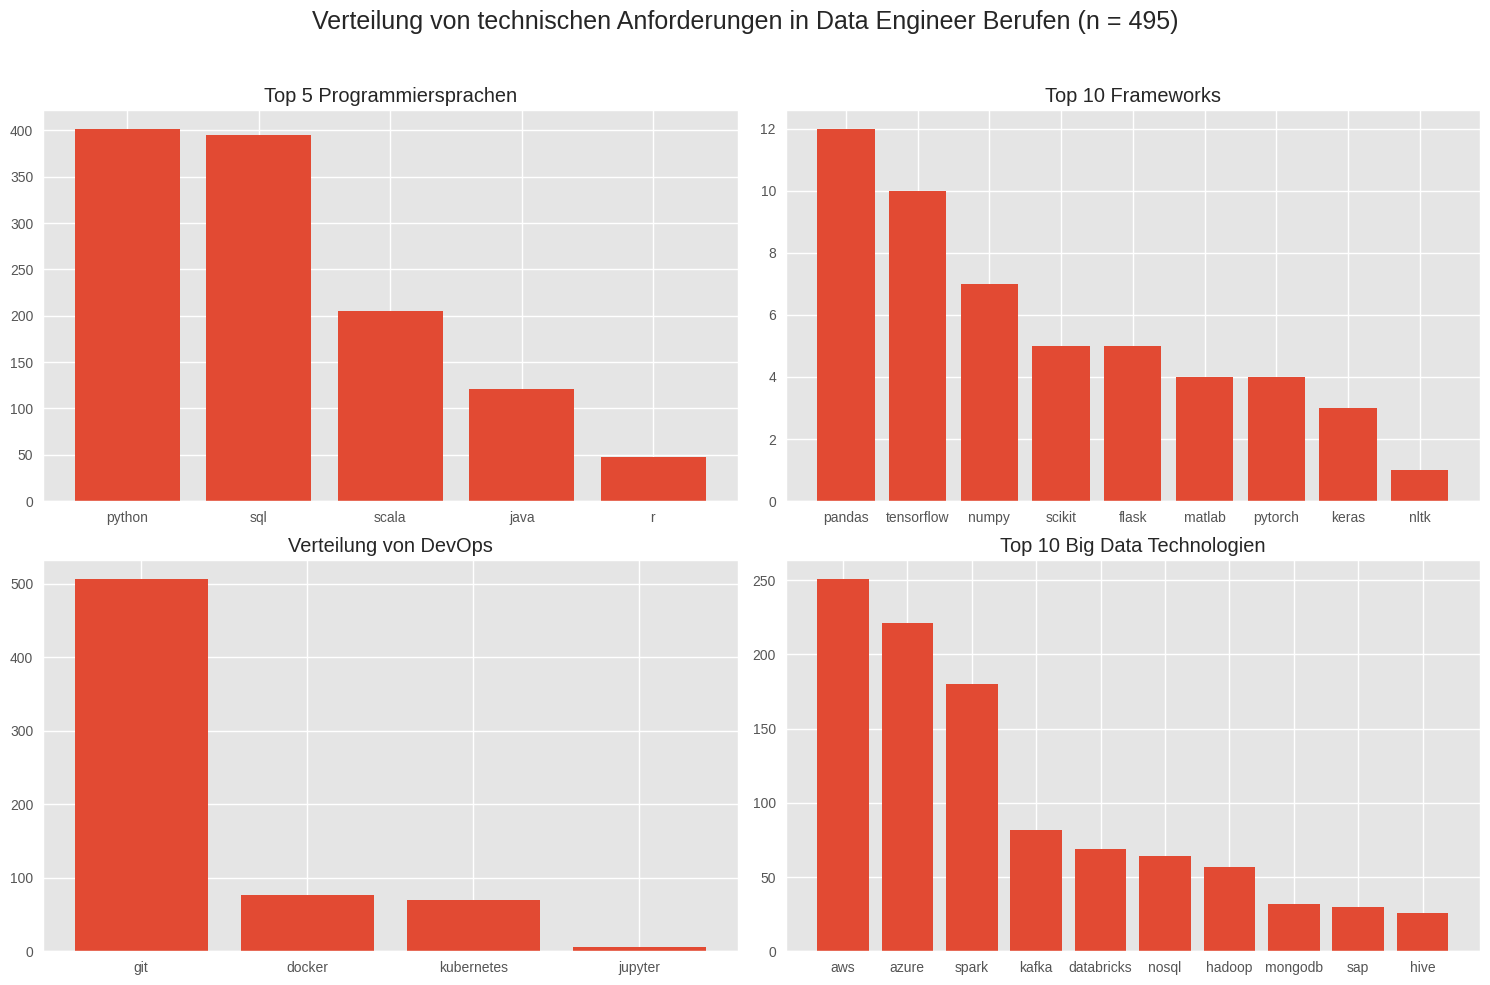

In [313]:
fig, (ax1, ax2) = plt.subplots(2, 2, constrained_layout=False, figsize=(15,10))
fig.suptitle(f"Verteilung von technischen Anforderungen in Data Engineer Berufen (n = {job_counts['data engineer']})", 
             fontsize=18)

ax1[0].bar(sortForPlot(lngs, 2)[0][:5],sortForPlot(lngs, 2)[1][:5])
ax1[0].set_title('Top 5 Programmiersprachen')

ax1[1].bar(sortForPlot(fwks, 2)[0][:10],sortForPlot(fwks, 2)[1][:10])
ax1[1].set_title('Top 10 Frameworks')

ax2[0].bar(sortForPlot(dps, 2)[0],sortForPlot(dps, 2)[1])
ax2[0].set_title('Verteilung von DevOps')

ax2[1].bar(sortForPlot(bgdt, 2)[0][:10],sortForPlot(bgdt, 2)[1][:10])
ax2[1].set_title('Top 10 Big Data Technologien')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

Text(0.5, 1.0, 'akademischer Grad')

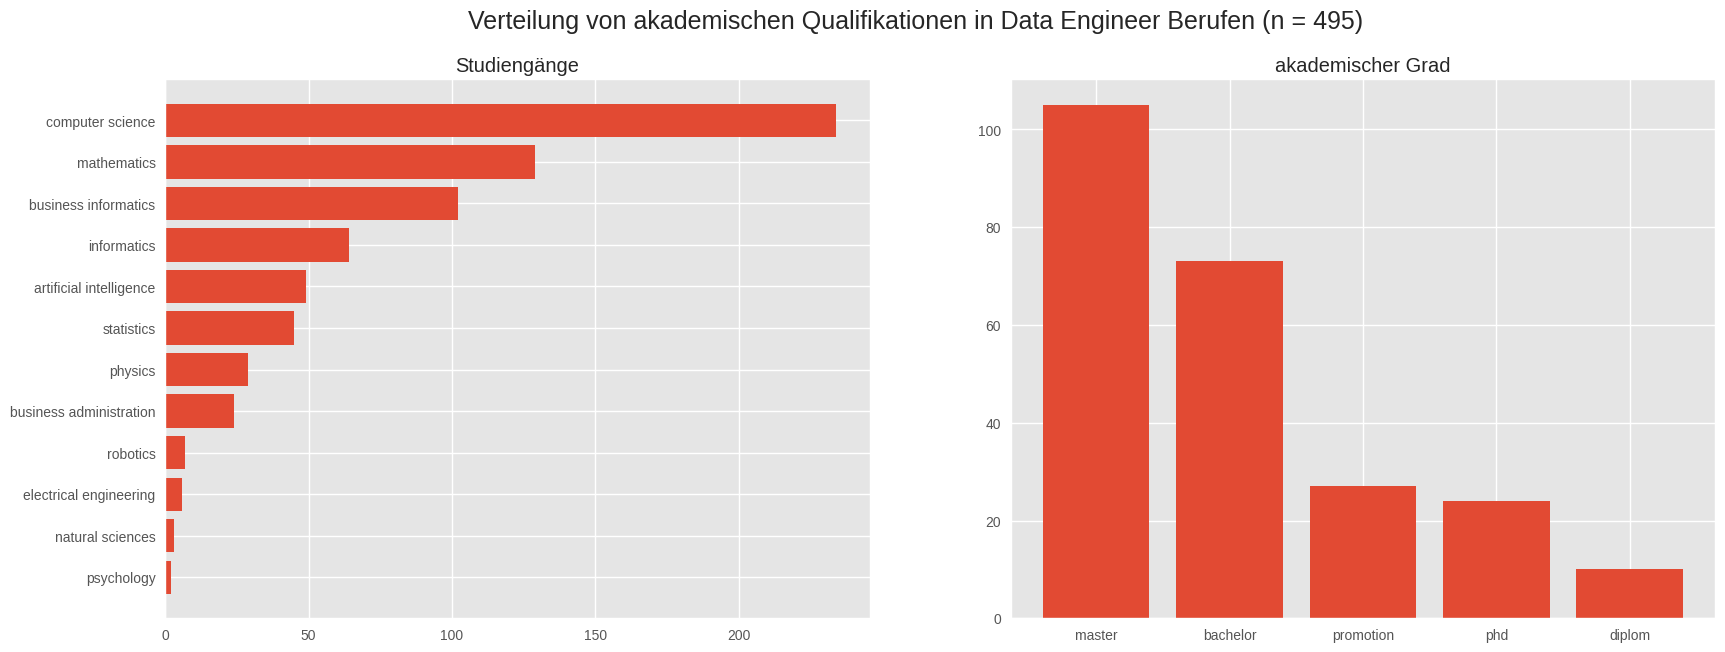

In [497]:
fig, ax = plt.subplots(1, 2, constrained_layout=False, figsize=(20,7))
fig.suptitle(f"Verteilung von akademischen Qualifikationen in Data Engineer Berufen (n = {job_counts['data engineer']})", 
             fontsize=18)
ax[0].barh(sortForPlot(dgr, 2)[0],sortForPlot(dgr, 2)[1])
ax[0].invert_yaxis()
ax[0].set_title('Studiengänge')

ax[1].bar(sortForPlot(edct, 2)[0],sortForPlot(edct, 2)[1])
ax[1].set_title('akademischer Grad')

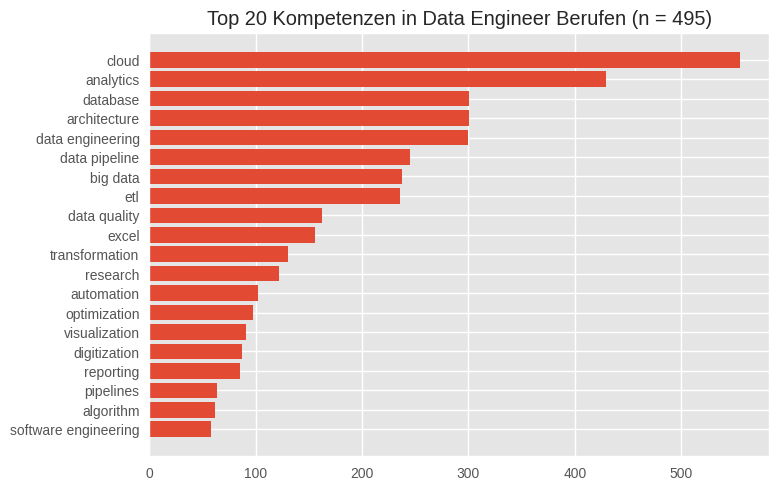

In [315]:
plt.barh(sortForPlot(skls, 2)[0][:20],sortForPlot(skls, 2)[1][:20])

plt.gca().invert_yaxis()
plt.title(f"Top 20 Kompetenzen in Data Engineer Berufen (n = {job_counts['data engineer']})") 
plt.show()

**AI Engineer** <a class="anchor" id="chapter5_4"></a>

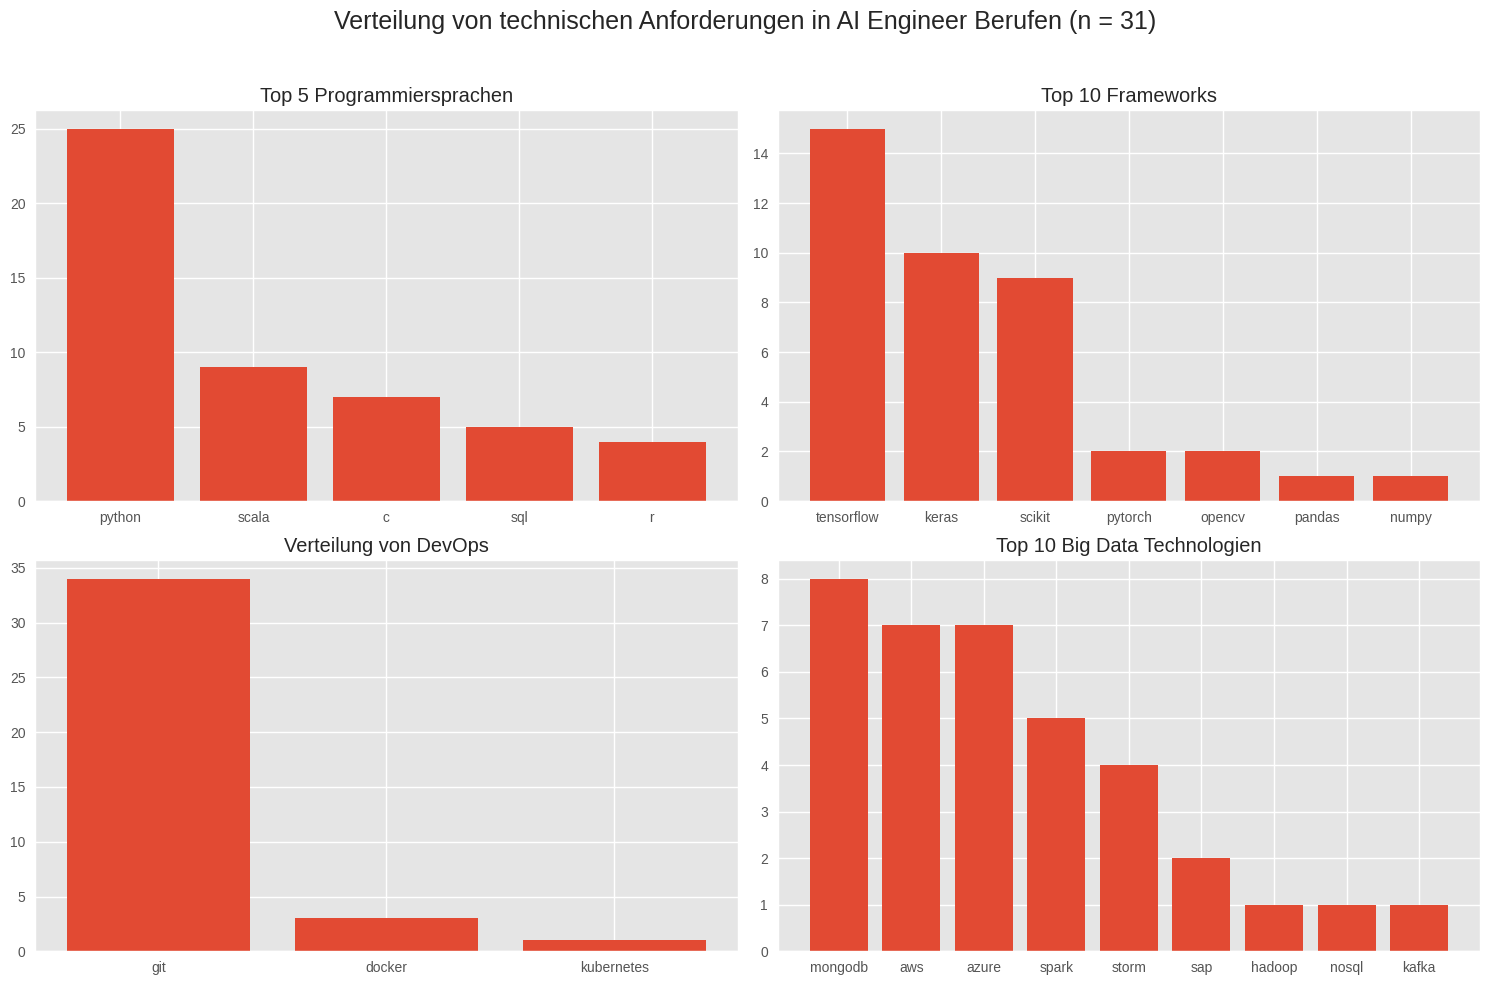

In [316]:
fig, (ax1, ax2) = plt.subplots(2, 2, constrained_layout=False, figsize=(15,10))
fig.suptitle(f"Verteilung von technischen Anforderungen in AI Engineer Berufen (n = {job_counts['ai engineer']})", 
             fontsize=18)

ax1[0].bar(sortForPlot(lngs, 4)[0][:5],sortForPlot(lngs, 4)[1][:5])
ax1[0].set_title('Top 5 Programmiersprachen')

ax1[1].bar(sortForPlot(fwks, 4)[0][:10],sortForPlot(fwks, 4)[1][:10])
ax1[1].set_title('Top 10 Frameworks')

ax2[0].bar(sortForPlot(dps, 4)[0],sortForPlot(dps, 4)[1])
ax2[0].set_title('Verteilung von DevOps')

ax2[1].bar(sortForPlot(bgdt, 4)[0][:10],sortForPlot(bgdt, 4)[1][:10])
ax2[1].set_title('Top 10 Big Data Technologien')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

Text(0.5, 1.0, 'akademischer Grad')

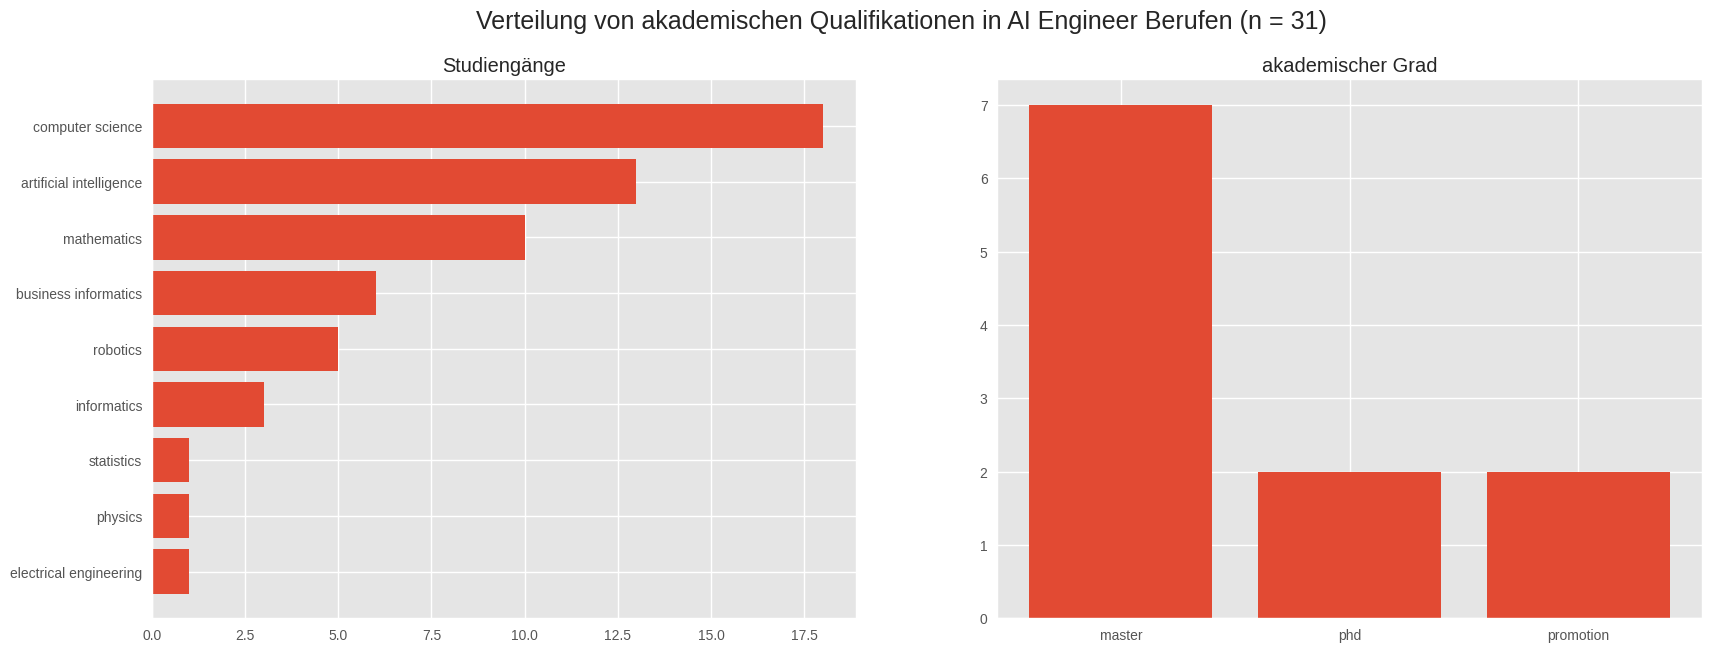

In [496]:
fig, ax = plt.subplots(1, 2, constrained_layout=False, figsize=(20,7))
fig.suptitle(f"Verteilung von akademischen Qualifikationen in AI Engineer Berufen (n = {job_counts['ai engineer']})", 
             fontsize=18)
ax[0].barh(sortForPlot(dgr, 4)[0],sortForPlot(dgr, 4)[1])
ax[0].invert_yaxis()
ax[0].set_title('Studiengänge')

ax[1].bar(sortForPlot(edct, 4)[0],sortForPlot(edct, 4)[1])
ax[1].set_title('akademischer Grad')

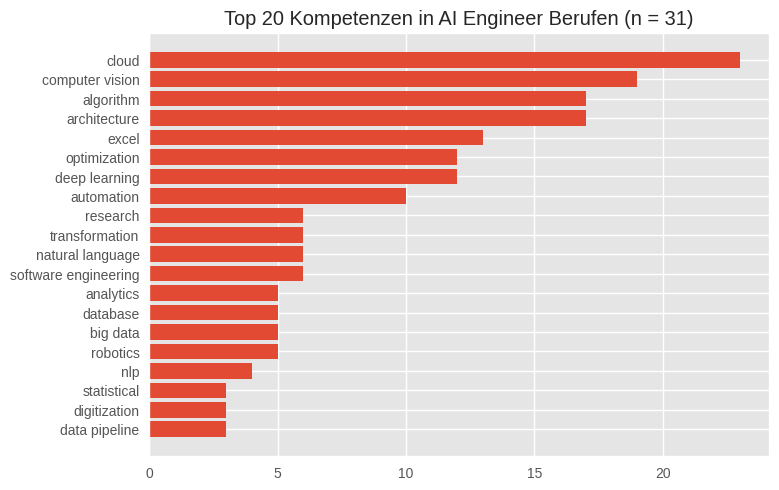

In [319]:
plt.barh(sortForPlot(skls, 4)[0][:20],sortForPlot(skls, 4)[1][:20])

plt.gca().invert_yaxis()
plt.title(f"Top 20 Kompetenzen in AI Engineer Berufen (n = {job_counts['ai engineer']})") 
plt.show()

**ML Engineer** <a class="anchor" id="chapter5_5"></a>

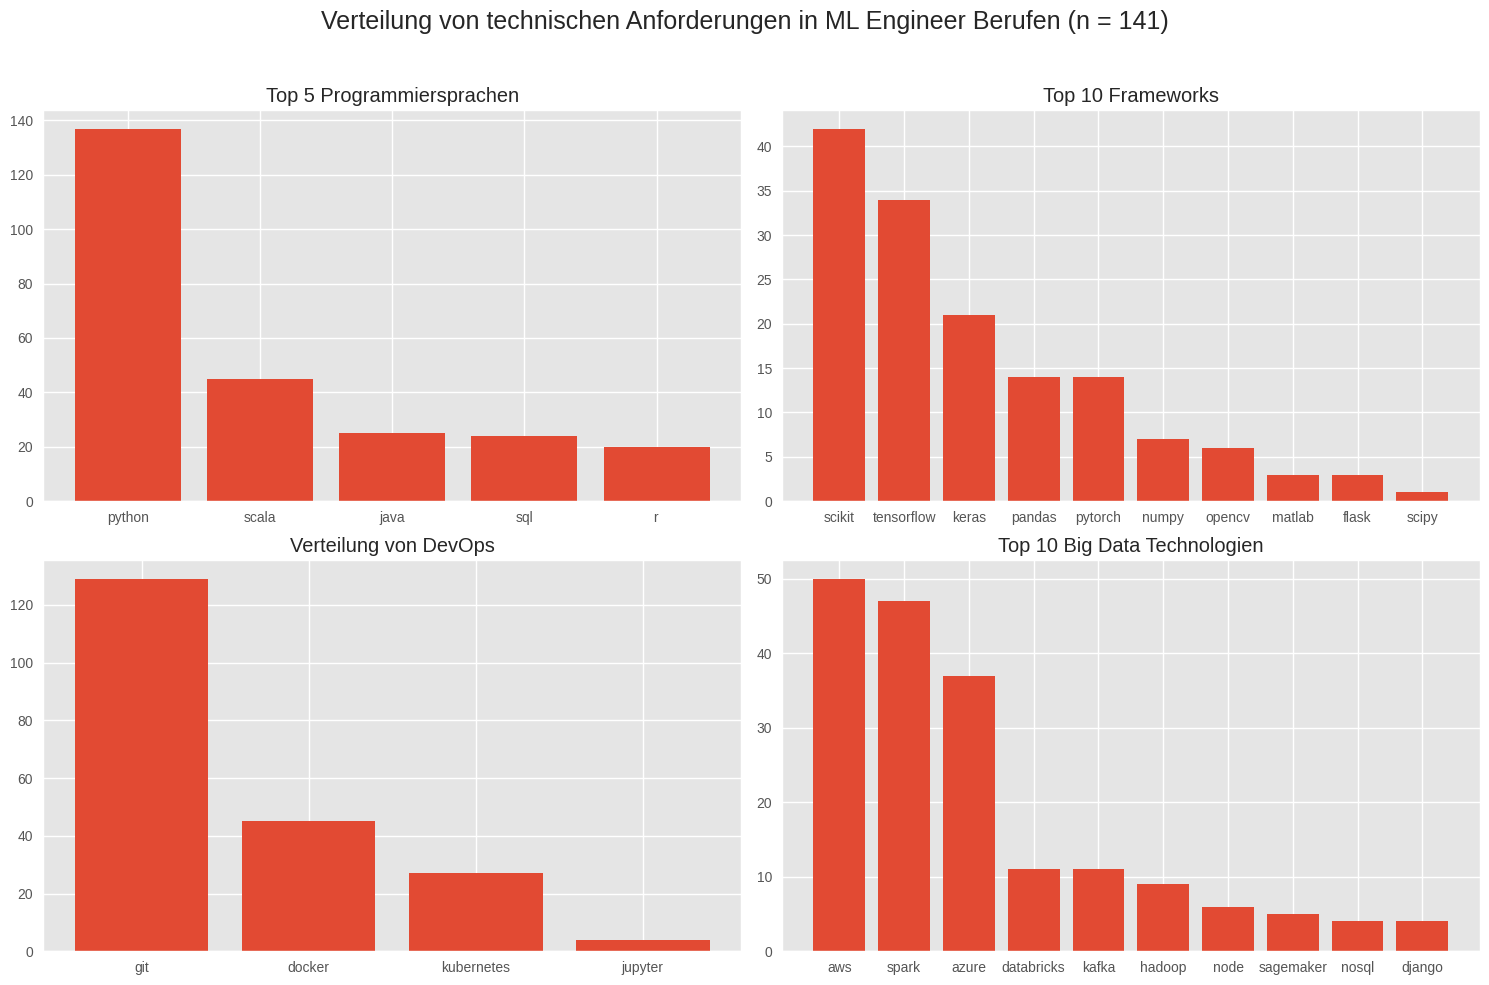

In [320]:
fig, (ax1, ax2) = plt.subplots(2, 2, constrained_layout=False, figsize=(15,10))
fig.suptitle(f"Verteilung von technischen Anforderungen in ML Engineer Berufen (n = {job_counts['ml engineer']})", 
             fontsize=18)

ax1[0].bar(sortForPlot(lngs, 6)[0][:5],sortForPlot(lngs, 6)[1][:5])
ax1[0].set_title('Top 5 Programmiersprachen')

ax1[1].bar(sortForPlot(fwks, 6)[0][:10],sortForPlot(fwks, 6)[1][:10])
ax1[1].set_title('Top 10 Frameworks')

ax2[0].bar(sortForPlot(dps, 6)[0],sortForPlot(dps, 6)[1])
ax2[0].set_title('Verteilung von DevOps')

ax2[1].bar(sortForPlot(bgdt, 6)[0][:10],sortForPlot(bgdt, 6)[1][:10])
ax2[1].set_title('Top 10 Big Data Technologien')

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

Text(0.5, 1.0, 'akademischer Grad')

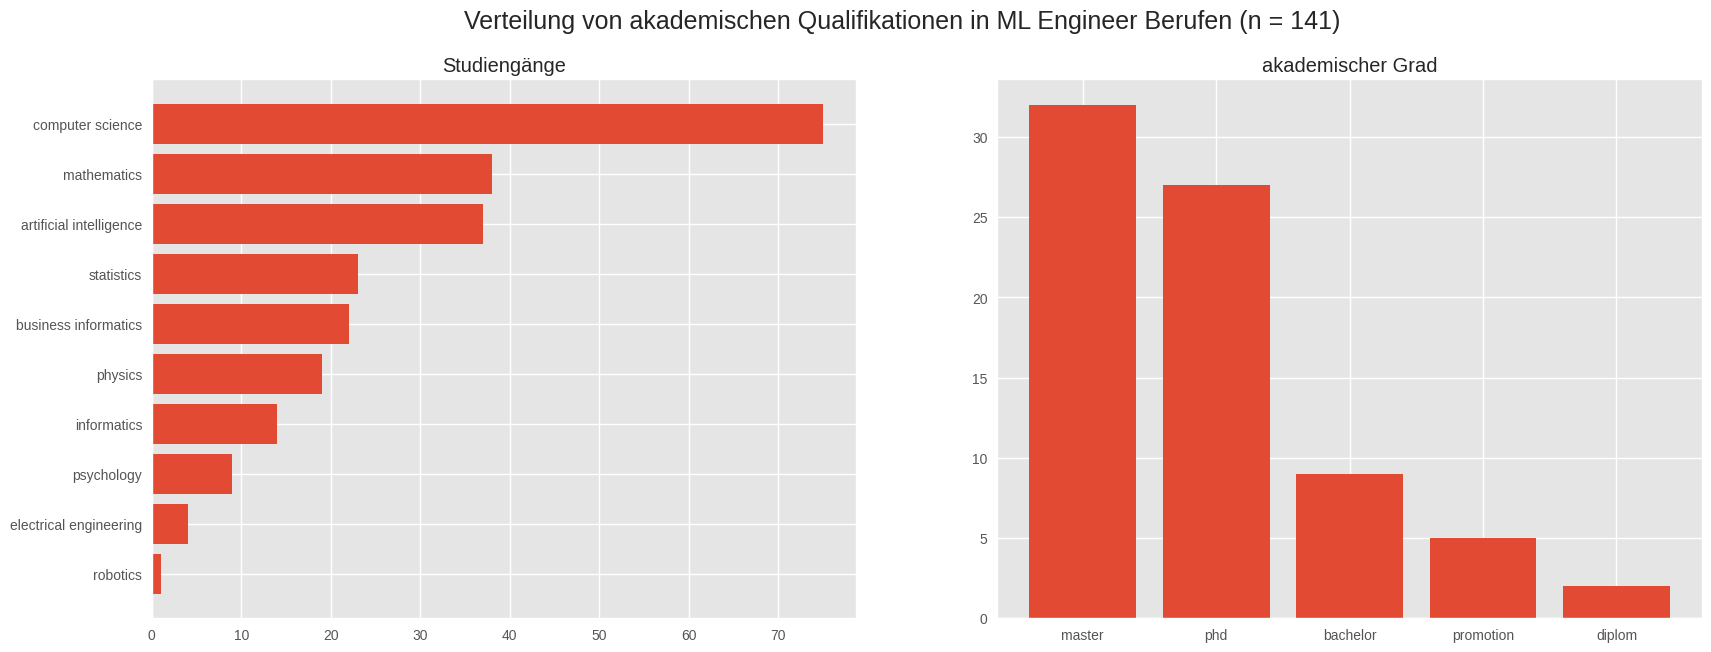

In [494]:
fig, ax = plt.subplots(1, 2, constrained_layout=False, figsize=(20,7))
fig.suptitle(f"Verteilung von akademischen Qualifikationen in ML Engineer Berufen (n = {job_counts['ml engineer']})", 
             fontsize=18)
ax[0].barh(sortForPlot(dgr, 6)[0],sortForPlot(dgr, 6)[1])
ax[0].invert_yaxis()
ax[0].set_title('Studiengänge')

ax[1].bar(sortForPlot(edct, 6)[0],sortForPlot(edct, 6)[1])
ax[1].set_title('akademischer Grad')

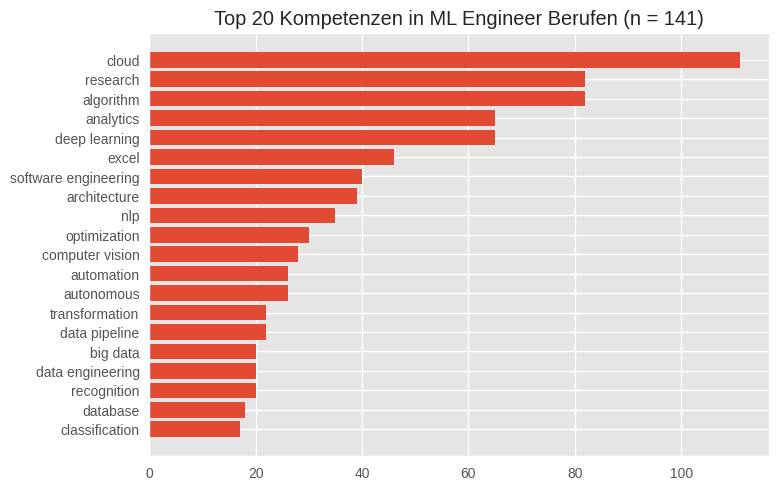

In [322]:
plt.barh(sortForPlot(skls, 6)[0][:20],sortForPlot(skls, 6)[1][:20])

plt.gca().invert_yaxis()
plt.title(f"Top 20 Kompetenzen in ML Engineer Berufen (n = {job_counts['ml engineer']})") 
plt.show()

**Berufe im Vergleich** <a class="anchor" id="chapter5_6"></a>

In [80]:
#Erstellt einen balancierten Datensatz mit den 3 Data-Berufen
ds_sample = df_trans[(df_trans['data scientist'] == 1) & (df_trans['data engineer'] == 0) & (df_trans['data analyst'] == 0)].sample(n=400, random_state=50)
de_sample = df_trans[(df_trans['data scientist'] == 0) & (df_trans['data engineer'] == 1) & (df_trans['data analyst'] == 0)].sample(n=400, random_state=50)
da_sample = df_trans[(df_trans['data scientist'] == 0) & (df_trans['data engineer'] == 0) & (df_trans['data analyst'] == 1)].sample(n=400, random_state=50)  
sample_list = [ds_sample, de_sample, da_sample]
data_sample = pd.concat(sample_list, ignore_index=True)

In [373]:
#Entfernt die nicht gebrauchten Berufe 
drop = ['link_text', 'ai', 'ai engineer', 'computer vision', 'deep learning', 'ml', 'ml engineer' ,'other', 'tokens']
data_sample = data_sample.drop(drop, axis = 1)

In [384]:
#Erstellt Dataframes mit den Anforderungen 
lngs_data = createDF(languages_count_data)
fwks_data = createDF(frameworks_count_data)
dps_data = createDF(devops_count_data)
bgdt_data = createDF(bigdata_count_data)
edct_data =createDF(education_count_data)
skls_data =createDF(skills_count_data)
dgr_data =createDF(degree_count_data)

In [543]:
#colum_names = ['scikit', 'sklearn']
#fwks_data['scikit'] = fwks_data[colum_names].sum(axis=1)
#fwks_data = fwks_data.drop('sklearn', axis=1)

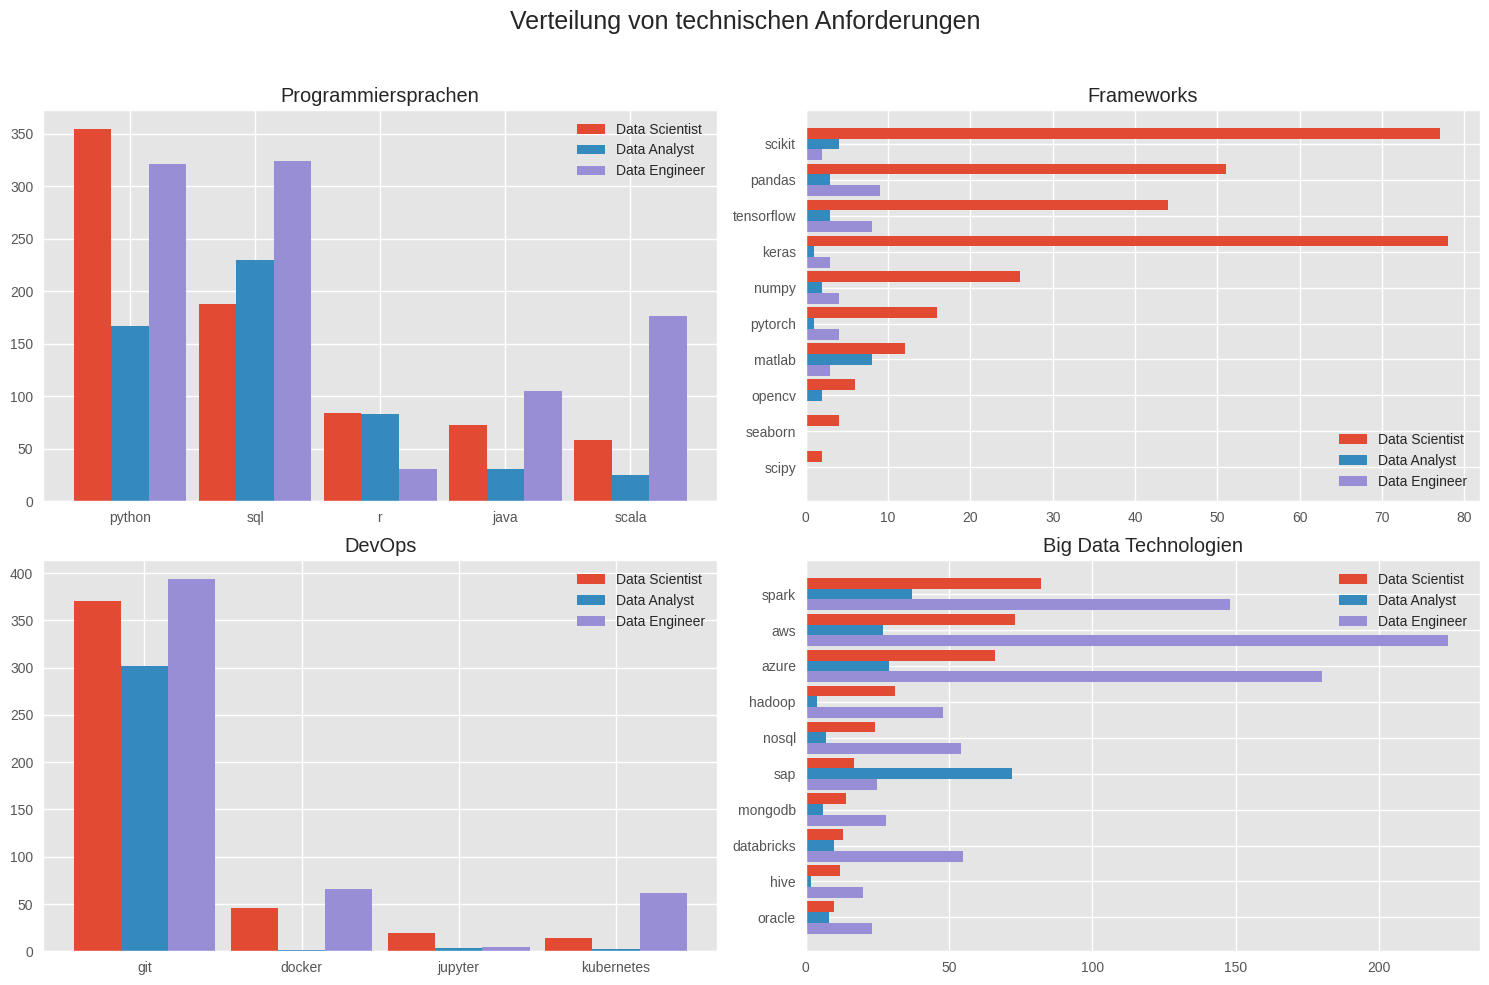

In [555]:
fig, (ax1, ax2) = plt.subplots(2, 2, constrained_layout=False, figsize=(15,10))
fig.suptitle(f"Verteilung von technischen Anforderungen", 
             fontsize=18)
width = 0.3

x = np.arange(len([* lngs_data.iloc[0].to_dict().values()][:5]))
ax1[0].bar(x-width, [* lngs_data.iloc[0].to_dict().values()][:5], width, label = 'Data Scientist')
ax1[0].bar(x, [* lngs_data.iloc[1].to_dict().values()][:5], width, label = 'Data Analyst')
ax1[0].bar(x+width, [* lngs_data.iloc[2].to_dict().values()][:5], width, label = 'Data Engineer')
ax1[0].set_xticks(x, [* lngs_data.iloc[0].to_dict().keys()][:5])
ax1[0].legend()
ax1[0].set_title('Programmiersprachen')

x = np.arange(len([* fwks_data.iloc[0].to_dict().values()][:10]))
ax1[1].barh(x-width, [* fwks_data.iloc[0].to_dict().values()][:10], width, label = 'Data Scientist')
ax1[1].barh(x, [* fwks_data.iloc[1].to_dict().values()][:10], width, label = 'Data Analyst')
ax1[1].barh(x+width, [* fwks_data.iloc[2].to_dict().values()][:10], width, label = 'Data Engineer')
ax1[1].set_yticks(x, [* fwks_data.iloc[0].to_dict().keys()][:10])
ax1[1].legend()
ax1[1].invert_yaxis()
ax1[1].set_title('Frameworks')

x = np.arange(len([* dps_data.iloc[0].to_dict().values()]))
ax2[0].bar(x-width, [* dps_data.iloc[0].to_dict().values()], width, label = 'Data Scientist')
ax2[0].bar(x, [*dps_data.iloc[1].to_dict().values()], width, label = 'Data Analyst')
ax2[0].bar(x+width, [* dps_data.iloc[2].to_dict().values()], width, label = 'Data Engineer')
ax2[0].set_xticks(x, [* dps_data.iloc[0].to_dict().keys()])
ax2[0].legend()
ax2[0].set_title('DevOps')


x = np.arange(len([* bgdt_data.iloc[0].to_dict().values()][:10]))
ax2[1].barh(x-width, [* bgdt_data.iloc[0].to_dict().values()][:10], width, label = 'Data Scientist')
ax2[1].barh(x, [*bgdt_data.iloc[1].to_dict().values()][:10], width, label = 'Data Analyst')
ax2[1].barh(x+width, [* bgdt_data.iloc[2].to_dict().values()][:10], width, label = 'Data Engineer')
ax2[1].set_yticks(x, [* bgdt_data.iloc[0].to_dict().keys()][:10])
ax2[1].legend()
ax2[1].invert_yaxis()
ax2[1].set_title('Big Data Technologien')


fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

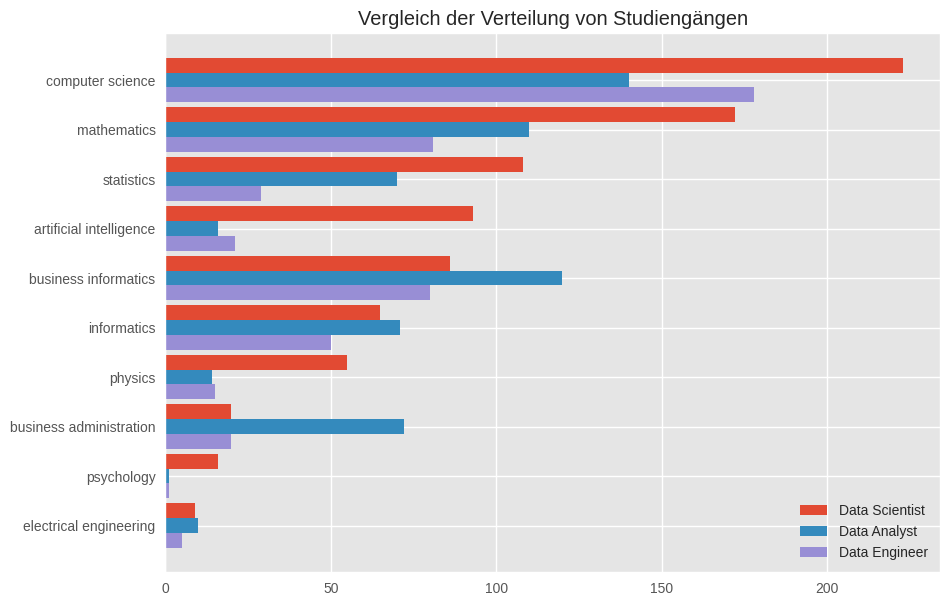

In [559]:
width = 0.3
x = np.arange(len([* dgr_data.iloc[0].to_dict().values()][:10]))
plt.figure(figsize=(10,7))
plt.barh(x-width, [* dgr_data.iloc[0].to_dict().values()][:10], width, label = 'Data Scientist')
plt.barh(x, [* dgr_data.iloc[1].to_dict().values()][:10], width, label = 'Data Analyst')
plt.barh(x+width, [* dgr_data.iloc[2].to_dict().values()][:10], width, label = 'Data Engineer')
plt.title(f"Vergleich der Verteilung von Studiengängen")
plt.yticks(x, [* dgr_data.iloc[0].to_dict().keys()][:10])
plt.gca().invert_yaxis()
plt.legend()

plt.show()

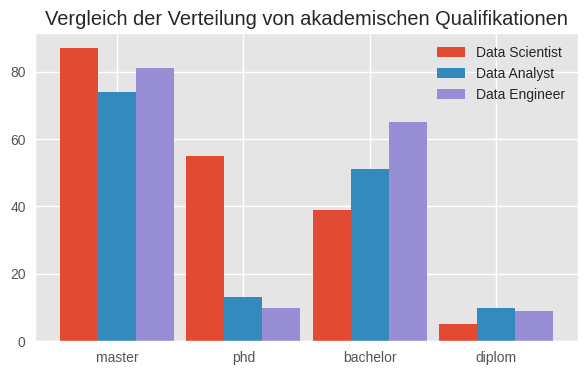

In [507]:
x = np.arange(len([* edct_data.iloc[0].to_dict().values()]))
plt.figure(figsize=(7,4))
plt.bar(x-width, [* edct_data.iloc[0].to_dict().values()], width, label = 'Data Scientist')
plt.bar(x, [* edct_data.iloc[1].to_dict().values()], width, label = 'Data Analyst')
plt.bar(x+width, [* edct_data.iloc[2].to_dict().values()], width, label = 'Data Engineer')
plt.title(f"Vergleich der Verteilung von akademischen Qualifikationen")
plt.xticks(x, [* edct_data.iloc[0].to_dict().keys()])
plt.legend()

plt.show()

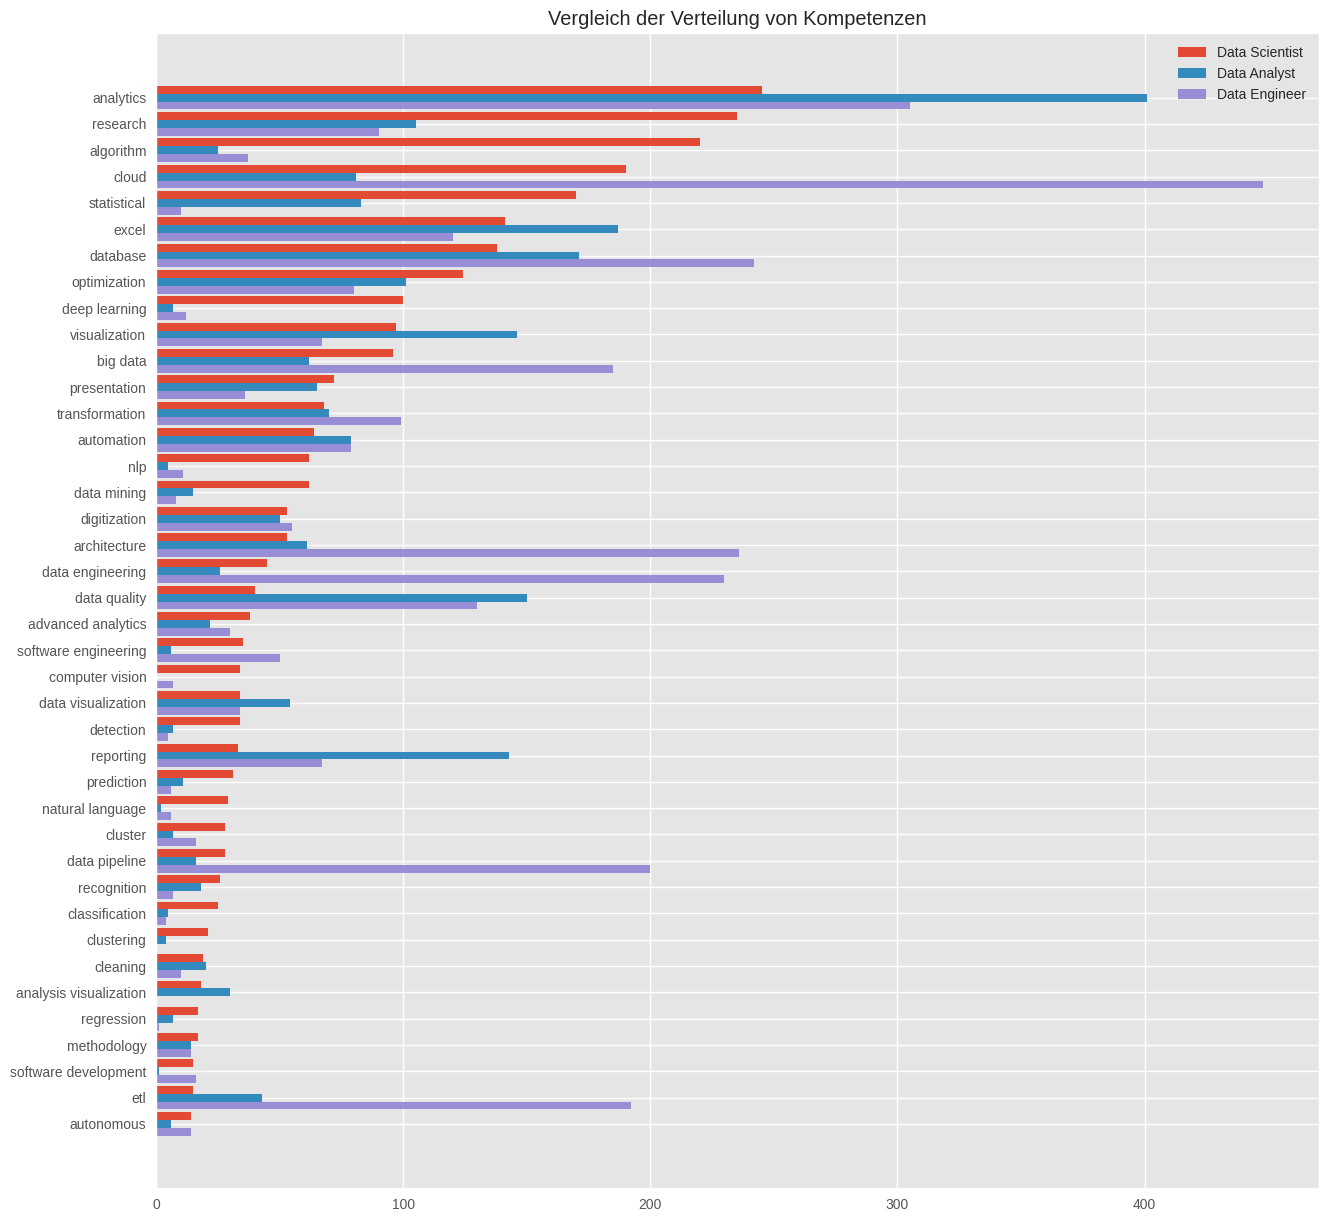

In [520]:
width = 0.3
x = np.arange(len([* skls_data.iloc[0].to_dict().values()][:40]))
plt.figure(figsize=(15,15))
plt.barh(x-width, [* skls_data.iloc[0].to_dict().values()][:40], width, label = 'Data Scientist')
plt.barh(x, [* skls_data.iloc[1].to_dict().values()][:40], width, label = 'Data Analyst')
plt.barh(x+width, [* skls_data.iloc[2].to_dict().values()][:40], width, label = 'Data Engineer')
plt.title(f"Vergleich der Verteilung von Kompetenzen")
plt.yticks(x, [* skls_data.iloc[0].to_dict().keys()][:40])
plt.gca().invert_yaxis()
plt.legend()

plt.show()